In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans

In [2]:
cd weibo

/Users/herculesgao/Desktop/master_thesis/weibo


In [12]:
#convert csv to df 
def file_to_df(Address):
    import jieba
    pd.set_option("display.max_rows", 300, "display.max_columns", 300) #setup rows and columns display
    word_collection=[]
    container=[]
    container_total=[]
    train_df = pd.read_excel(Address)[['博主id','博主','博文','发布时间', '转发数', '评论数', '点赞数']]
    train_df=train_df.rename(columns={'博主id': "userid", "博主": "username",'博文':"content",'发布时间':"date", 
                             '转发数':'num_repost', '评论数':'num_comment', '点赞数':"num_like"})
    train_df = train_df.assign(separating_content= train_df["content"].apply(lambda x: ("/".join(jieba.cut(x,cut_all=False)))))
    for i in train_df.separating_content:
        container=[x.lower() for x in i.split("/")]#get rid of the lower case
        container_total.append(container)
        word_collection+=container
    train_df.separating_content=container_total
    return train_df

def remove_poly_punc(train_df):
    for i in range(len(train_df.separating_content)):
        for j in train_df.separating_content[i]:
            if j ==" "or len(j)==0 or len(j)==1:
                 train_df.separating_content[i].remove(j)
            else:
                for t in j:
                    try:
                        if ord(t)<=64: #remove punctuation
                            train_df.separating_content[i].remove(j)
                        if (ord(t)>=65277 and ord(t)<=65382):#remomve chinese pingyin
                            train_df.separating_content[i].remove(j)
                        if (ord(t)>=8215 and ord(t)<=8224): #remove chinese punctuation
                            train_df.separating_content[i].remove(j)
                    except:
                        print("Error!")
    return train_df

def remove_repetitive(train_df):
        print("Before cleaning the bot-generated feeds, the shape of matrix is: ", train_df.shape)
        list1 = []
        for i in range(len(train_df["content"])):
            for j in range(i + 1, len(train_df["content"])):
                if train_df["content"][i] == train_df["content"][j]:
                    print("index: i, j:", i,j,"content:",train_df["content"][j])
                    list1.append(j)
        list1 = set(list1)
        print(list1)
        train_df = train_df.drop(list1, axis=0).reset_index(drop=True)
        print("After cleaning the bot-generated feeds, the shape of matrix is: ", train_df.shape)
        return train_df
    
#create the dataframe for ranking of the freq of words
def two_sorted_df(dataframe_em):
    from collections import Counter
    all_word =[]
    for i in range(len(dataframe_em)):
        for j in dataframe_em[i]:
            all_word.append(j) 
    C=Counter(all_word)
    df_apperance = pd.DataFrame.from_dict(C, orient='index').reset_index()
    df_apperance = df_apperance.rename(columns={'index':'words', 0:'count'})
    df_apperance=df_apperance.sort_values(["count"], ascending=False).reset_index(drop=True)
    sorted_df = df_apperance
#     print(df_apperance)

    return sorted_df

def get_apperance_matrix(wrds,txts):#can speed up with dictionary
    import time
    st = time.time()
    M = np.zeros((len(wrds),len(txts)))#create the empty matrix
    words = list(wrds) 
    texts = list(txts) 
    for j in range(len(texts)): 
        for i in range(len(words)):
            for k in texts[j]:
                if words[i] == k:
                    M[i,j]+=1 #appear more than once in matrix
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    return M

def remove_stopping_word(train_df):
    import stopwordsiso as stopwords
    stopping_words = stopwords.stopwords("zh")
    for i in range(len(train_df.separating_content)):
        for j in train_df.separating_content[i]:
            if j in stopping_words:
#                 print("We found a stopping word",j)
                train_df.separating_content[i].remove(j)
    return train_df
def get_incidence_matrix(num_text=2942):
    train_df = file_to_df("weibo_trainin_data_0401_0531.xlsx")
    import plotly.express as px
    train_df = remove_stopping_word(train_df)
    train_df = train_df.loc[:num_text]
    n=10
    while n > 0: 
        n-=1 
        print(n)
        train_df= remove_poly_punc(train_df)
    train_df= remove_repetitive(train_df)
    word_df= two_sorted_df(train_df.separating_content)
    word_df = word_df[word_df["count"]>1].reset_index(drop = True)
    fig = px.scatter(word_df, x= list(range(len(word_df["count"]))), y="count",title="Occurrence for Each Word")
    fig.show()
    M_raw_after=get_apperance_matrix(word_df["words"],train_df["separating_content"])
    return M_raw_after, train_df, num_text,word_df#checked

def computeTF(wordDict, bow):
    tfDict ={}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict
def computeIDF(docList,total_doc):
    import math
    idfDict ={}
    N = len(total_doc)
    idfDict = dict.fromkeys(docList.keys(),0)
    for word, val in docList.items():
        idfDict[word] = math.log10(N/float(val))
    return idfDict
def computeTFIDF(tfBow,idfs):
    tfidf ={}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf
def check_cosine(text1,text2):
    from numpy import dot
    from numpy.linalg import norm
    return dot(text1, text2)/(norm(text1)*norm(text2))

def getTFIDF(M_raw_after,sorted_df,train_df):
    import time
    from scipy import stats
    st = time.time()
    print("Before cleaning,",M_raw_after.shape)
    wordDict={}
    for i in range(len(sorted_df)):
        wordDict[sorted_df.iloc[i]["words"]] = 0
    print("Generating the dataframe for the incidence matrix")
    M_raw_df = pd.DataFrame(M_raw_after)
    for i in range(len(train_df["separating_content"][0])):
        if train_df["separating_content"][0][i] in wordDict.keys():
            wordDict[train_df["separating_content"][0][i]]+=1
    text1= computeTF(wordDict, M_raw_df[0])
    docList = {}
    for i in range(len(sorted_df["words"])):
        docList[sorted_df["words"][i]]= sorted_df["count"][i]

    idfs=computeIDF(docList,M_raw_df)
    d = computeTFIDF(text1,idfs)
    M_TFIDF = pd.DataFrame(d.items(), columns=['word', 'Text1'])
    n=1
    for i in range(1,len(train_df)):
        n+=1
        wordDict = dict.fromkeys(docList.keys(),0)
        for j in range(len(train_df["separating_content"][i])):
            if train_df["separating_content"][i][j] in wordDict.keys():
                wordDict[train_df["separating_content"][i][j]]+=1
                textn= computeTF(wordDict, M_raw_df[i])
                d = computeTFIDF(textn,idfs)
        stri = "Text"+str(n)
        M_TFIDF[stri]=d.values()
    

    li_bot = {}
    tem = []
    print("Start checking similarity!")
    for i in M_TFIDF.columns[1:-1]:
        li_bot[i]=[]
        for j in M_TFIDF.columns[1+M_TFIDF.columns.get_loc(i):-1]:
            if j not in tem:
                if check_cosine(M_TFIDF[i],M_TFIDF[j])>0.9 and stats.spearmanr(M_TFIDF[i],M_TFIDF[j])[0]>0.9:
                        li_bot[i].append(j)
#                         idx1 = [int(s)-1 for s in i if s.isdigit()]
#                         idx2 = [int(s)-1 for s in j if s.isdigit()]
#                         print(train_df.separating_content[idx1])
#                         print(train_df.separating_content[idx2])
                        tem.append(i)
                        tem.append(j)
    remove_li=[]
    for i in li_bot:
        if len(li_bot[i])!=0:
            remove_li.append(li_bot[i])
            
    remove_li = [j for i in remove_li for j in i]
                    
    M_TFIDF= M_TFIDF.drop(columns=remove_li)
    M_tfidf = M_TFIDF[M_TFIDF.columns[1:]].to_numpy()
    et = time.time()
    elapsed_time = et - st
    print("After cleaning,",M_TFIDF.shape)
    print('Execution time:', elapsed_time, 'seconds')

    return M_TFIDF,M_tfidf

# function of PCA for low_rank approximation 
def low_rank_approx(er, error_init, rank,B1, U,s,Vt):
    from numpy import linalg as LA
    while er > error_init:
        new_U = U[:,:rank] 
        new_s = s[:rank]
        new_Vt = Vt[:rank,:]
#         print(LA.norm(B1 - (new_s*new_U@new_Vt),"fro")**2)
        er = LA.norm(B1 - (new_s*new_U@new_Vt),"fro")**2
        rank+=1
    print(len(new_s))
    return new_U, new_s,new_Vt
def svd_train(M_tfidf):
    from numpy.linalg import svd 
    import plotly.express as px
    B1 = M_tfidf.copy() 

    #centerize the data
    B1 = M_tfidf.copy() 
    B1 -= np.mean(B1, axis=0)

    U, s, Vt = svd(B1, full_matrices=False)
    print("Check SVD with the original Matrix:",np.allclose(U @ np.diag(s) @ Vt, B1))
    
    fig = px.scatter(x= np.arange(1,len(s)+1), y=s,title="Plot of singular values",
                log_y=True, range_y=[10**(-20),10*2], range_x=[1,len(s)])

    fig.show()
    return U, s, Vt,B1
def cluster_variance(n,x):
    from sklearn.cluster import KMeans
    variances=[]
    kmeans=[]
    outputs=[]
    K=[i for i in range(1,n+1)]
    for i in range(1,n+1):
        variance=0
#         print("iteration:",i)
#         print("len(x):",len(x))
        if len(x)>200:
            model=KMeans(n_clusters=i,random_state=2).fit(x)
        else:
            model=KMeans(n_clusters=i,random_state=42).fit(x)
        kmeans.append(model)
        variances.append(model.inertia_)
        
    return variances,K,n


def new_svd_wvariance(init_rank,B1,U,s,Vt):
    import plotly.express as px
    error_init = 1e-16
    er = 1 
    n_U, n_s, n_Vt = low_rank_approx(er, error_init,init_rank,B1,U,s,Vt)
    # overall variance explained by the SVD
    R_sqr ={}  #numpy array

    # total = lambda x:sum(x)
    total_s = 0
    for i in n_s:
        total_s += i**2

    for i, j in enumerate(n_s):
        R_sqr[i+1]=(j**2)/total_s
    fig = px.scatter(x= np.arange(1,len(R_sqr)+1), y=R_sqr.values(), 
                 title="Plot of varince explained by PCs")

    fig.show()
    return n_U, n_s, n_Vt,R_sqr


def find_num_cluster(num_component,num_clust, n_U,n_s,n_Vt):
    import plotly.express as px
    new_B1 = n_U*n_s@n_Vt
    variances,K,n=cluster_variance(num_clust,new_B1)
    fig = px.line(x= K, y=variances, markers = True,
                 title="Inertia ( Total Distance )")

    fig.show()
    return new_B1

def check_component(pct,R_sqr):
    sum_v = 0
    for i, j in enumerate(R_sqr.values()):
        sum_v += j
        if sum_v >=pct:
            break
    print(i,"components capture over ",pct*100,
          "% of variance. \nAnd the sum of the explained variance for the these components:",sum_v)
    return i
    
def plot_cluster(num_c, B1,sorted_df):
    from sklearn.cluster import KMeans
    import plotly.express as px
    # define the model
    model = KMeans(n_clusters=num_c)
    # fit the model
    model.fit(B1)

    # show the plot
    B1_pca_df = pd.DataFrame(B1)
    idx = 0
    new_col = sorted_df['words'] # can be a list, a Series, an array or a scalar   
    B1_pca_df.insert(loc=idx, column='word', value=new_col)
    B1_pca_df['Segment'] = model.labels_

    fig = px.scatter(B1_pca_df,x= 0, y=1, 
                     title="Cluster by PCA components",color = 'Segment')

    fig.show()
    
    return B1_pca_df 

def reorganize_df(df):
    total_txt=[]
    for i in df['texts']:
        total_txt.append(i)
    df['texts'] = sorted(total_txt)
    return df

def LSAwPCA(num_texts):
    import plotly.express as px
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    
    M_raw_after, train_df, num_text,sorted_df = get_incidence_matrix(num_texts)
    M_TFIDF,M_tfidf = getTFIDF(M_raw_after,sorted_df,train_df)
    U, s, Vt,B1 = svd_train(M_tfidf)
    init_rank = int(input("Please input the number of initial rank you want:"))
    n_U, n_s, n_Vt,R_sqr = new_svd_wvariance(init_rank,B1,U,s,Vt)
    pct = float(input("Please input the percentage of explained variance you want:"))
    num_comp = check_component(pct,R_sqr)

    new_B1 = find_num_cluster(num_comp,4*num_comp, n_U[:,:num_comp],n_s[:num_comp],n_Vt[:num_comp,:])
    num_clu = int(input("Please specify the num of clusters you want for word classification:"))
    B1_pca_df = plot_cluster(num_clu, new_B1,sorted_df)
    class_words={}
    for i in range(num_clu):
        class_words[i]=[B1_pca_df[B1_pca_df['Segment']==i]['word']]
    
    words_df = pd.DataFrame(class_words)
    num_ls =[]
    for i in M_TFIDF.columns[1:]:
        num = ""
        for s in i:   
            if s.isdigit():
                num+=s
        num_ls.append(int(num)-1)

    content = [train_df["content"][i] for i in num_ls]

    pca = PCA(n_components=num_comp)
    pca.fit(new_B1)

    txt_w = pca.components_.T
    # We fit K means using the transformed data from the PCA.
    wcss=[]
    for i in range (1,M_TFIDF.shape[1]):
        kmeans_pca = KMeans(n_clusters =i, random_state=40)
        kmeans_pca.fit(txt_w)
        wcss.append(kmeans_pca.inertia_)
    txt_df = pd.DataFrame(txt_w)
    plt.figure(figsize =(10,8))

    fig = px.line(x= range(1,M_TFIDF.shape[1]), y=wcss, markers = True,
                 title="Inertia")
    fig.show()
    
    num_clu = int(input("Please specify the num of clusters you want for text classification:"))
    kmeans_pca = KMeans(n_clusters= num_clu, init = "k-means++",random_state = 40 )

    kmeans_pca.fit(txt_w)
    text= M_TFIDF.T
    text.columns = M_TFIDF['word']
    text = text.drop('word',axis = 0)
    text_pca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_w)],axis = 1)
    text_pca.columns.values[-num_clu:] = ['W'+str(i+1) for i in range(num_clu)]

    text_pca['Segment'] = kmeans_pca.labels_

    text_pca.index = [i for i in range(M_TFIDF.shape[1]-1)]

    text_pca['content'] = content
    class_df = {}
    for i in range(num_clu):
        print(i,text_pca[text_pca['Segment']==i]['content'])
        class_df[i]= text_pca[text_pca['Segment']==i]['content']
    class_pca = pd.DataFrame(class_df.items(), columns=['class','texts'])
    leng= []
    for i in range(len(class_pca['class'])):
        temp = []
        for j in class_pca.iloc[i]['texts']:
            temp.append(j)
        class_pca['texts'][i]= temp
        leng.append(len(temp))
    class_pca['length'] = leng
    class_pca = reorganize_df(class_pca)
    return words_df, class_pca

def LSAwSPCA(num_texts):
    import plotly.express as px
    from sklearn.cluster import KMeans
    from sparsepca import spca
    import time
    from sklearn.decomposition import PCA
    
    M_raw_after, train_df, num_text,sorted_df = get_incidence_matrix(num_texts)
    M_TFIDF,M_tfidf = getTFIDF(M_raw_after,sorted_df,train_df)
    U, s, Vt,B1 = svd_train(M_tfidf)
    init_rank = int(input("Please input the number of initial rank you want:"))
    n_U, n_s, n_Vt,R_sqr = new_svd_wvariance(init_rank,B1,U,s,Vt)
    pct = float(input("Please input the percentage of explained variance you want:"))
    num_comp = check_component(pct,R_sqr)

    new_B1 = find_num_cluster(num_comp,4*num_comp, n_U[:,:num_comp],n_s[:num_comp],n_Vt[:num_comp,:])
    num_ls =[]
    for i in M_TFIDF.columns[1:]:
        num = ""
        for s in i:   
            if s.isdigit():
                num+=s
        num_ls.append(int(num)-1)

    content = [train_df["content"][i] for i in num_ls]

    st = time.time()
    fin_sprout  = spca(new_B1, lambda1= 0.1 * np.ones((6, 1)), lambda2=0.1, k=6)
    print(f"Finite: {fin_sprout['iter']} iterations with final value {fin_sprout['f_manpg']},sparsity {fin_sprout['sparsity']}, timediff {fin_sprout['time']}.")
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    txt_spca = fin_sprout['loadings']
    

    # We fit K means using the transformed data from the PCA.
    wcss=[]
    for i in range (1,M_TFIDF.shape[1]):
        kmeans_pca = KMeans(n_clusters =i, init="k-means++", random_state=40)
        kmeans_pca.fit(txt_spca)
        wcss.append (kmeans_pca.inertia_)

    fig = px.line(x= range(1,M_TFIDF.shape[1]), y=wcss, markers = True,
                 title="K-means with SPCA clustering")
    fig.show()
    k = int(input("Please specify the num of clusters you want for text classification:"))

    kmeans_spca = KMeans(n_clusters= k, init = "k-means++",random_state = 40 )

    kmeans_spca.fit(txt_spca)
    text= M_TFIDF.T
    text.columns = M_TFIDF['word']
    text = text.drop('word',axis = 0)

    class_df = {}
    text_spca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_spca)],axis = 1)
    text_spca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]

    text_spca['Segment'] = kmeans_spca.labels_
    

    text_spca.index = content

    for i in range(k):
        print(i,text_spca[text_spca['Segment']==i].index)
        class_df[i]= text_spca[text_spca['Segment']==i].index

    class_spca = pd.DataFrame(class_df.items(), columns=['class','texts'])
    leng= []
    for i in range(len(class_spca['class'])):
        temp = []
        for j in class_spca.iloc[i]['texts']:
            temp.append(j)
        class_spca['texts'][i]= temp
        leng.append(len(temp))
    class_spca['length'] = leng
    class_spca = reorganize_df(class_spca)
    return fin_sprout['x'],fin_sprout['loadings'],class_spca

    
def compare(df1,df2):
    if len(df1['texts'].compare(df2['texts']))==0:
        print("LSA with PCA and LSA with SPCA give the same clusters!")
    else:
        print("two methods give different clusters.",
              "Here self respresents LSA with PCA and other represents LSA with SPCA",
              df1['texts'].compare(df2['texts']))
    


## Take only first 70


In [6]:
words_pca, text_class_pca = LSAwPCA(70)

9
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
8
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
7
Error!
Error!
Error!
Error!
Error!
Error!
6
Error!
5
4
3
2
1
0
Before cleaning the bot-generated feeds, the shape of matrix is:  (71, 8)
index: i, j: 0 2 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c
index: i, j: 0 5 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c
index: i, j: 0 20 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c
index: i, j: 0 22 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。

Execution time: 0.004895210266113281 seconds
Before cleaning, (106, 31)
Generating the dataframe for the incidence matrix
Start checking similarity!
After cleaning, (106, 22)
Execution time: 0.07922101020812988 seconds
Check SVD with the original Matrix: True


Please input the number of initial rank you want:15
21


Please input the percentage of explained variance you want:0.8
6 components capture over  80.0 % of variance. 
And the sum of the explained variance for the these components: 0.8051286078320499


Please specify the num of clusters you want for word classification:7


Please specify the num of clusters you want for text classification:8
0 6    又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/NY...
Name: content, dtype: object
1 13    #带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4月...
Name: content, dtype: object
2 1             刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​
3     我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜的...
5     加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止...
7     堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得...
8     【22fall纽约大学 offer播报】专业：computerl engineeringBG...
9     问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我选...
11                                纽约大学求二手群！家具厨具啥的都可～ ​
12                   ? 朋友圈加了一个在纽约大学学电影的姐姐 我真的真的好羡慕啊?  ​
15             问#纽约大学# LLM和#哥伦比亚大学# LLM回国区别大吗?答没多大差别的 ​
16    我趣。。之前就对那个刘彰有点子好感就是说rap好牛又蛮帅的、、刚刚才看到他娘的美国纽约大学在...
18            nyu纽约大学目前支持上海校区之前因为要回本校而犹豫的小伙伴们可以来咯#留学# ​
19    纽约大学研究生offerMasters #美国留学# in applied urban sc...
Name: content, dtype: object
3 2    #美国留学答疑# 商科双非一本学校，有两段internships，现在GPA很低，只有2.8.

<ipython-input-5-3621de247aa4>:392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Figure size 720x576 with 0 Axes>

## Kmeans with SPCA:

In [7]:
x,loading_spca,text_class_spca = LSAwSPCA(70)

9
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
8
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
7
Error!
Error!
Error!
Error!
Error!
Error!
6
Error!
5
4
3
2
1
0
Before cleaning the bot-generated feeds, the shape of matrix is:  (71, 8)
index: i, j: 0 2 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c
index: i, j: 0 5 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c
index: i, j: 0 20 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c
index: i, j: 0 22 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。

index: i, j: 44 48 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 44 62 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 44 64 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 44 65 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 44 66 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 44 67 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始

Execution time: 0.004438877105712891 seconds
Before cleaning, (106, 31)
Generating the dataframe for the incidence matrix
Start checking similarity!
After cleaning, (106, 22)
Execution time: 0.08175802230834961 seconds
Check SVD with the original Matrix: True


Please input the number of initial rank you want:15
21


Please input the percentage of explained variance you want:0.8
6 components capture over  80.0 % of variance. 
And the sum of the explained variance for the these components: 0.8051286078320499


Finite: 894 iterations with final value -104.55012540443707,sparsity 0.8492063492063492, timediff 0.21916584799998873.
Execution time: 0.21940302848815918 seconds


<ipython-input-5-3621de247aa4>:437: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.

<ipython-input-5-3621de247aa4>:437: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.

<ipython-input-5-3621de247aa4>:437: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.

<ipython-input-5-3621de247aa4>:437: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.

<ipython-input-5-3621de247aa4>:437: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (15). Possibly due to duplicate points in X.

<ipython-input-5-3621de247aa4>:437: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.

<ipy

Please specify the num of clusters you want for text classification:8
0 Index(['又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/NYU）艺术研究所（Institute of Fine Arts/IFA）的艺术史与考古学硕士项目（MA History of Art and Archaeology）的offer，在此表示热烈祝贺！纽约大学是世界顶级的研究型大学，其艺术研究所（IFA）是世界著名的艺术史研究机构， ​  展开c'], dtype='object')
1 Index(['#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4月8日24时，上海本轮疫情已累计报告阳性感染者超15万人，4月以来，上海每日报告的本土感染者连日上涨，7日、8日两天更是单日新增超2万。国家感染性疾病临床医学研究中心主任、深圳市第三人民医院党委书记刘磊告诉健康 ​  展开c'], dtype='object')
2 Index(['刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​',
       '我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜的人群比不戴的感染率大幅降低。这个对我们预防新冠带来一个新的角度。晚安。 ​',
       '加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止了俺现在就跟吃了屎一样无语 ​',
       '堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得严不让他接触电子产品，以后可以尽情玩了，我是不是在耽误学霸学习 ​',
       '【22fall纽约大学 offer播报】专业：computerl engineeringBG:中山大学光电信息科学与工程 GPA3.6/4.0 GRE327 雅7.0/6.0 实习两段TL: 2.15申请 3.11offer ​',
       '问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我选NYU ​',
       '纽约大学求二手群！家具厨具啥的

<ipython-input-5-3621de247aa4>:471: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
compare(text_class_pca,text_class_spca)

LSA with PCA and LSA with SPCA give the same clusters!


In [202]:
from sklearn.decomposition import SparsePCA
import time

st = time.time()
transformer = SparsePCA(n_components=6,
                        alpha=1e16, ridge_alpha=0.01,
                        tol=1e16,random_statea = 42)
transformer.fit(new_B1)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.007799863815307617 seconds


In [203]:
t_spca = transformer.transform(new_B1)
txt_spca =transformer.components_.T

In [204]:
txt_spca

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

## NOT WORKING!!

https://xinging-birds.github.io/AManPG/

In [207]:
pip install sparsepca


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [238]:
from sparsepca import spca
fin_sprout  = spca(new_B1, lambda1= 0.1 * np.ones((6, 1)), lambda2=0.1, k=6)
print(f"Finite: {fin_sprout['iter']} iterations with final value {fin_sprout['f_manpg']}, sparsity {fin_sprout['sparsity']}, timediff {fin_sprout['time']}.")




Finite: 382 iterations with final value -104.54906927041894, sparsity 0.8333333333333334, timediff 0.0940622110001641.


In [239]:
txt_spca = fin_sprout['loadings']

In [240]:
# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,22):
    kmeans_pca = KMeans(n_clusters =i, init="k-means++", random_state=84)
    kmeans_pca.fit(txt_spca)
    wcss.append (kmeans_pca.inertia_)

<ipython-input-240-20272d01f082>:5: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.

<ipython-input-240-20272d01f082>:5: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.

<ipython-input-240-20272d01f082>:5: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.

<ipython-input-240-20272d01f082>:5: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.

<ipython-input-240-20272d01f082>:5: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (15). Possibly due to duplicate points in X.

<ipython-input-240-20272d01f082>:5: ConvergenceWarning:

Number of distinct clusters (10) found smaller than n_clusters (16). Possibly due to duplicate points in X.

<ipy

Text(0, 0.5, 'WCSS')

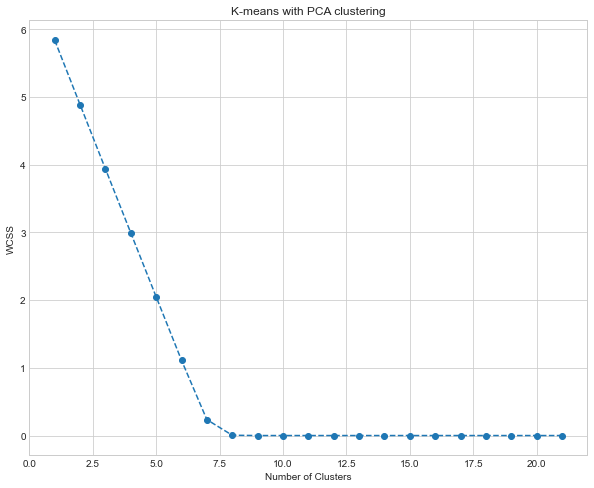

In [241]:
plt.figure(figsize =(10,8))
plt.plot(range(1,22), wcss, marker ='o', linestyle ="--")
plt.title( "K-means with PCA clustering")
plt.xlabel ('Number of Clusters')
plt.ylabel('WCSS')

In [242]:
kmeans_pca = KMeans(n_clusters= 8, init = "k-means++",random_state = 42 )

kmeans_pca.fit(txt_spca)


KMeans(random_state=42)

In [244]:
text_spca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_spca)],axis = 1)
text_spca.columns.values[-8:] = ['W'+str(i+1) for i in range(8)]

text_spca['Segment'] = kmeans_pca.labels_

text_spca.index = content

for i in range(8):
    print(i,text_spca[text_spca['Segment']==i].index)



0 Index(['又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/NYU）艺术研究所（Institute of Fine Arts/IFA）的艺术史与考古学硕士项目（MA History of Art and Archaeology）的offer，在此表示热烈祝贺！纽约大学是世界顶级的研究型大学，其艺术研究所（IFA）是世界著名的艺术史研究机构， ​  展开c'], dtype='object')
1 Index(['刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​',
       '我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜的人群比不戴的感染率大幅降低。这个对我们预防新冠带来一个新的角度。晚安。 ​',
       '加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止了俺现在就跟吃了屎一样无语 ​',
       '堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得严不让他接触电子产品，以后可以尽情玩了，我是不是在耽误学霸学习 ​',
       '【22fall纽约大学 offer播报】专业：computerl engineeringBG:中山大学光电信息科学与工程 GPA3.6/4.0 GRE327 雅7.0/6.0 实习两段TL: 2.15申请 3.11offer ​',
       '问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我选NYU ​',
       '纽约大学求二手群！家具厨具啥的都可～ ​', '? 朋友圈加了一个在纽约大学学电影的姐姐 我真的真的好羡慕啊?  ​',
       '问#纽约大学# LLM和#哥伦比亚大学# LLM回国区别大吗?答没多大差别的 ​',
       '我趣。。之前就对那个刘彰有点子好感就是说rap好牛又蛮帅的、、刚刚才看到他娘的美国纽约大学在读？？？？谁不爱学霸哥哥真真纯路人哈 现在好感蹭蹭up ​',
       'nyu纽约大学目前支持上海校区之前因为要回本校而犹豫的小伙伴们可以来咯#留学# ​',
       '纽约大学研究生offerMa

## Take 140 texts

In [251]:
M_raw_after, train_df, num_text,sorted_df = get_incidence_matrix(140)

M_TFIDF,M_tfidf = getTFIDF(M_raw_after,sorted_df,train_df)
U, s, Vt,B1 = svd_train(M_tfidf)

9
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Erro

index: i, j: 34 44 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 34 48 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 34 62 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 34 64 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 34 65 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 34 66 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始

Execution time: 0.049809932708740234 seconds
Before cleaning, (380, 94)
Generating the dataframe for the incidence matrix
Start checking similarity!
After cleaning, (380, 82)
Execution time: 0.6076650619506836 seconds
Check SVD with the original Matrix: True


In [252]:
init_rank = 10
n_U, n_s, n_Vt,R_sqr = new_svd_wvariance(init_rank,B1)

pct = 0.8

check_component(pct,R_sqr)



0.02701779774830807
0.025851628787280784
0.024708099044766427
0.023574901284388786
0.022482731692427035
0.021442650586104773
0.020455864847930577
0.019494070505056058
0.01856155200665909
0.017673539630407374
0.0168212533983212
0.015976498466472512
0.015142462293869537
0.014330766930751953
0.013586299497823641
0.012905037294245287
0.012251043322156185
0.011621787315810171
0.011009891415469658
0.010405772720498167
0.009865020730559398
0.00937493414502927
0.008898833999261035
0.008445793731510652
0.008008368041820773
0.007587690041922318
0.007180213173075872
0.006816192322104271
0.006460062903770332
0.00610627385343548
0.005769506478224067
0.005438997806980911
0.00511879957062126
0.004805236769129937
0.0045024727131664204
0.004225737634035613
0.0039509397772798105
0.0036958846826587537
0.0034485669763080103
0.0032133424092301134
0.0029860353170907588
0.0027653377153049213
0.002563788131988972
0.0023735122317993344
0.002198464956113376
0.002029613003069841
0.0018693712533697942
0.001714761

33 components capture over  80.0 % of variance. 
And the sum of the explained variance for the these components: 0.8102703639127388


In [253]:
#n_U[:,:6],n_s[:6],n_Vt[6:,:]
new_B1 = find_num_cluster(33,50, n_U[:,:33],n_s[:33],n_Vt[:33,:])

In [254]:
B1_pca_df = plot_cluster(28, new_B1,sorted_df)

class_words={}
for i in range(28):
    class_words[i]=[B1_pca_df[B1_pca_df['Segment']==i]['word']]
    
words_df = pd.DataFrame(class_words)

for i in words_df:
    print(i)
    for j in words_df[i]:
        print(j)
    print("\n")



0
222     就读
295    留学生
325     家庭
342     一笔
353     小梁
354     女士
355     妈妈
Name: word, dtype: object


1
7        训练
8        男孩
9        张骏
12       成绩
14       母亲
17       孩子
18       终于
19       收到
20       语言
22       名校
23       开始
24     日复一日
25       交流
26       正常
28       经过
29       听障
30       励志
31       进行
32      高强度
33       听力
34       日前
35       苏州
36      通知书
37       从小
38       医生
39       诊断
40       天生
41       事业
42       重度
43       残疾
44       植入
45       人工
46       耳蜗
47      张丽娜
48       放下
51     名列前茅
172      感谢
Name: word, dtype: object


2
0      纽约大学
2        留学
50       美本
64       院校
66       本科
67       托福
92       特点
124      解读
149      点为
154      热门
157    数据分析
171      冉维
173    首席专家
174      前程
175      特质
176      解析
185      有何
187      日晚
229      雅思
268      太原
316      考研
Name: word, dtype: object


3
1         录取
15        专业
16        硕士
49        大学
61        数学
98       计算机
133       工程
138      统计学
169       应用
216      南加州
219  

## text_classification by weight:

In [255]:
num_ls =[]
for i in M_TFIDF.columns[1:]:
    num = ""
    for s in i:   
        if s.isdigit():
            num+=s
    num_ls.append(int(num)-1)

content = [train_df["content"][i] for i in num_ls]

pca = PCA(n_components=33)
pca.fit(new_B1)

txt_w = pca.components_.T

# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,82):
    kmeans_pca = KMeans(n_clusters =i, random_state=100)
    kmeans_pca.fit(txt_w)
    wcss.append(kmeans_pca.inertia_)
    print(kmeans_pca.inertia_)

32.38959175959207
31.39760866393808
30.46543088606111
29.47944194416381
28.570028752252828
27.526243156169507
26.49953760521295
25.652652030139336
24.551741529759287
23.632544611898922
22.708816634305947
21.802869893751165
20.81677702507288
20.127807489733648
18.929252957654974
18.113452983024537
16.967364864364196
16.17585963185735
15.196768712279598
14.316636957621784
13.49086566940167
12.548686879427933
11.603306251398607
10.641096472405414
9.829454636532624
8.908188938236272
8.090052000119314
7.345373706310815
6.588039215391387
5.800960391843473
5.0812624134965425
4.21354874419781
3.7572322544069934
3.170630225550565
2.724236849502815
2.4588892176543267
2.2395632731844737
2.0240617204624813
1.8499960317701025
1.6524301974833437
1.5071761141859277
1.4074391610901615
1.3036001232681778
1.2119080091939054
1.0969709038920898
1.0037191399287742
0.9296692221936266
0.8709149164440544
0.7784285358610687
0.7036119214155824
0.6229100112499327
0.5784461563808577
0.5314991161176458
0.480809710

In [258]:
import plotly.express as px
txt_df = pd.DataFrame(txt_w)

plt.figure(figsize =(10,8))
# fig = px.scatter(range(1,82), wcss, marker ='o', linestyle ="--")
# plt.title( "K-means with PCA clustering")
# plt.xlabel ('Number of Clusters')
# plt.ylabel('WCSS')

fig = px.line(x= range(1,82), y=wcss, markers = True,
                 title="K-means with PCA clustering")
fig.show()

<Figure size 720x576 with 0 Axes>

In [320]:
kmeans_pca = KMeans(n_clusters= 40, init = "k-means++",random_state = 42 )

kmeans_pca.fit(txt_w)



KMeans(n_clusters=40, random_state=42)

In [323]:
text= M_TFIDF.T
text.columns = M_TFIDF['word']
text = text.drop('word',axis = 0)
k = 40 #cluster
text_pca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_w)],axis = 1)
text_pca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]

text_pca['Segment'] = kmeans_pca.labels_

text_pca.index = [i for i in range(81)]

text_pca['content'] = content
class_df = {}
for i in range(k):
    print(i,text_pca[text_pca['Segment']==i]['content'])
    class_df[i]= text_pca[text_pca['Segment']==i]['content']
class_pca_140 = pd.DataFrame(class_df.items(), columns=['class','texts'])
leng= []
for i in range(len(class_pca_140['class'])):
    temp = []
    for j in class_pca_140.iloc[i]['texts']:
        temp.append(j)
    class_pca_140['texts'][i]= temp
    leng.append(len(temp))
class_pca_140['length'] = leng

0 68    #美国留学答疑#请问gpa3.6 GRE315 申请哥大和nyu I/O psych难进嘛？...
Name: content, dtype: object
1 27    【22fall录取】#美国留学# Offer：纽约大学 生物统计学硕士 （NYU Maste...
28    【22fall录取】#美国留学# Offer：纽约大学 对外英语教学硕士 （NYU MA T...
53    【录取】#美国留学# Offer：纽约大学 整合营销硕士 （NYU MS in Integr...
Name: content, dtype: object
2 9     问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我选...
78    问#纽约大学# 的FE，#帝国理工学院# 的Fintech选哪个呀?答如果是我，我选NYUN...
Name: content, dtype: object
3 60    2022纽约大学本科录取数据分析? 美本热门申请院校有何特点? 解析纽约大学的院校特质? 前...
74    2022纽约大学本科录取数据分析? 美本热门申请院校有何特点? 解析纽约大学的院校特质前程留...
Name: content, dtype: object
4 31    中国本土教育完全没有培养科学家的土壤  高中那时寄宿在我家的美国朋友有三位 他们三位现在一位...
Name: content, dtype: object
5 1             刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​
5     加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止...
7     堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得...
8     【22fall纽约大学 offer播报】专业：computerl engineeringBG...
11                                纽约大学求二手群！家具厨具啥的都可～ ​
12                   ? 朋友圈加了一个在纽约大学学电影的姐姐 我真的真的好羡慕啊?  ​
15 

<ipython-input-323-b54399193b39>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [324]:
class_pca_140

class                                              texts  length
0       0  [#美国留学答疑#请问gpa3.6 GRE315 申请哥大和nyu I/O psych难进嘛...       1
1       1  [【22fall录取】#美国留学# Offer：纽约大学 生物统计学硕士 （NYU Mast...       3
2       2  [问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我...       2
3       3  [2022纽约大学本科录取数据分析? 美本热门申请院校有何特点? 解析纽约大学的院校特质? ...       2
4       4  [中国本土教育完全没有培养科学家的土壤  高中那时寄宿在我家的美国朋友有三位 他们三位现在一...       1
5       5  [刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​, 加了...      29
6       6  [#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4...       1
7       7  [#张纯烨 主持名场面# 新相亲：国家级健将级美女运动员赵珺，二十一岁保研纽约大学！新相亲：...       1
8       8  [这部凉山篮球村的纪录片拿下美国三项大奖O这部凉山篮球村的纪录片拿下美国三项大奖采访撰文 |...       1
9       9  [抗疫求助 （座標）浦東金橋 碧云庭服務公寓（事由）這個小區14棟樓，居民大半是外籍、港澳...       1
10     10  [【#工薪家庭每年花近100万供孩子留学#，妈妈感慨： 我从来不考虑投入产出】杭州方女士的儿...       1
11     11  [又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/N...       1
12     12  [当当网优惠码300-60：YW Q2FF，当当网优惠码150-30：Q69RT W。【自恋...       1
13     13  [#后浪电影课# 严艺之：导演该如何讲故事？全方位实战攻略！? 时间：5月24日-6月8日（...       1
14     14  [美国曼尼斯音乐学院（Mannes School of Music at The New S...       1
15     15  [【美国? ? 留学｜纽约大学】☑️纽约大学法学院地处曼哈顿，地理位置得天独厚，是近十几年来...       1
16     16  [#世毕盟上海# #留学申请季# 【捷报】均分60，纽约大学录取来了！祝贺西浦学员！热烈祝贺...       2
17     17  [#美国研究生2022录取# 恭喜JY[庆祝][庆祝][庆祝]喜获美国纽约大学生物硕士录取开...       1
18     18  [纽约大学nyu小姐姐已就位，来就滴滴哦时代广场经典大楼 Biltmore1b1b拼室友 ...       1
19     19  [纽约大学 【LIC个人转租】LIC河滨豪楼，担保已付，带家具居住设施，可拎包入住超大客厅...       1
20     20  [#选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国...       1
21     21  [纽约大学NYU Applied Urban Science and Informatics...       1
22     22  [NJ楼王已推出8月份房源！！想要租房的小伙伴们千万不要错过机会了！今年房源过度紧张！stu...       2
23     23  [#美国留学答疑# 商科双非一本学校，有两段internships，现在GPA很低，只有2....       1
24     24  [#阿尔·帕西诺作品大赏# 【熟肉·中字】阿尔·帕西诺传记电影——舞台与电影 Babbleo...       1
25     25  [#清流君的申请经验#❓23fall美研申请，金工好还是DS好？还有一年左右就要申请了，但自...       1
26     26  [【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书...       1
27     27  [纽约租房#兔子在纽约# 纽约的小伙伴看这里新楼盘♥️‼️NJ 新楼盘即将开盘‼️? ⏰5...       1
28     28  [刘彰，出生于广东省珠海市，就读于美国纽约大学数学与经济学专业，中国内地男说唱歌手，说唱音乐...       1
29     29  [好消息来啦? 22 Fall Shanghai study away 批复啦想留在上纽大校...       3
30     30  [纽约租房#兔子在纽约# 兔子独家房源? NYC的小哥哥小姐姐看这里♦️JP出4/5//6...       2
31     31  [请查收今日高端文案中心收获的录取：1. 纽约大学计算机工程专业硕士录取2. 南加州大学计算...       1
32     32  [我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜...       1
33     33  [#刘彰新歌AK Is Back#欢迎了解一下，纽约大学在读大学生，现役男团爱豆音乐创作人A...       1
34     34  [我趣。。之前就对那个刘彰有点子好感就是说rap好牛又蛮帅的、、刚刚才看到他娘的美国纽约大学...       3
35     35  [【22fall录取】#美国留学# Offer：埃塞克高等商学院 市场营销管理和数字营销 （...       3
36     36  [#小a的申请分享# ? ? ? ? 纽约大学金融数学硕士南京大学统计学学士? 【留学申请】...       1
37     37  [#留学##美国留学##纽约大学# ? ? NYU MOT 纽约大学技术管理硕士TANDON...       1
38     38  [#刘彰新歌AK Is Back#看I‘m proud all the fans 都站我身后...       1
39     39  [问#纽约大学# 的金工都录取什么样的人呀？答录取的人，主要由美本、海本、国内的话985和比...       1

## Kmeans with SPCA:


In [261]:
fin_sprout  = spca(new_B1, lambda1= 0.1 * np.ones((33, 1)), lambda2=0.1, k=33)
print(f"Finite: {fin_sprout['iter']} iterations with final value {fin_sprout['f_manpg']}, sparsity {fin_sprout['sparsity']}, timediff {fin_sprout['time']}.")




txt_spca = fin_sprout['loadings']

# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,82):
    kmeans_pca = KMeans(n_clusters =i, init="k-means++", random_state=84)
    kmeans_pca.fit(txt_spca)
    wcss.append (kmeans_pca.inertia_)

fig = px.line(x= range(1,82), y=wcss, markers = True,
                 title="K-means with SPCA clustering")
fig.show()


Finite: 1427 iterations with final value -371.4470764446601, sparsity 0.9120838009726898, timediff 1.9237590519996957.


<ipython-input-261-99263716bc04>:13: ConvergenceWarning:

Number of distinct clusters (62) found smaller than n_clusters (63). Possibly due to duplicate points in X.

<ipython-input-261-99263716bc04>:13: ConvergenceWarning:

Number of distinct clusters (62) found smaller than n_clusters (64). Possibly due to duplicate points in X.

<ipython-input-261-99263716bc04>:13: ConvergenceWarning:

Number of distinct clusters (62) found smaller than n_clusters (65). Possibly due to duplicate points in X.

<ipython-input-261-99263716bc04>:13: ConvergenceWarning:

Number of distinct clusters (62) found smaller than n_clusters (66). Possibly due to duplicate points in X.

<ipython-input-261-99263716bc04>:13: ConvergenceWarning:

Number of distinct clusters (62) found smaller than n_clusters (67). Possibly due to duplicate points in X.

<ipython-input-261-99263716bc04>:13: ConvergenceWarning:

Number of distinct clusters (62) found smaller than n_clusters (68). Possibly due to duplicate points in X.

In [325]:
k = 35


kmeans_pca = KMeans(n_clusters= k, init = "k-means++",random_state = 42 )

kmeans_pca.fit(txt_spca)

class_df = {}

text_spca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_spca)],axis = 1)
text_spca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]

text_spca['Segment'] = kmeans_pca.labels_

text_spca.index = content

for i in range(k):
    print(i,text_spca[text_spca['Segment']==i].index)
    class_df[i]= text_spca[text_spca['Segment']==i].index

class_spca_140 = pd.DataFrame(class_df.items(), columns=['class','texts'])
leng= []
for i in range(len(class_spca_140['class'])):
    temp = []
    for j in class_spca_140.iloc[i]['texts']:
        temp.append(j)
    class_spca_140['texts'][i]= temp
    leng.append(len(temp))
class_spca_140['length'] = leng

0 Index(['刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​',
       '加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止了俺现在就跟吃了屎一样无语 ​',
       '堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得严不让他接触电子产品，以后可以尽情玩了，我是不是在耽误学霸学习 ​',
       '【22fall纽约大学 offer播报】专业：computerl engineeringBG:中山大学光电信息科学与工程 GPA3.6/4.0 GRE327 雅7.0/6.0 实习两段TL: 2.15申请 3.11offer ​',
       '问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我选NYU ​',
       '纽约大学求二手群！家具厨具啥的都可～ ​', '? 朋友圈加了一个在纽约大学学电影的姐姐 我真的真的好羡慕啊?  ​',
       '问#纽约大学# LLM和#哥伦比亚大学# LLM回国区别大吗?答没多大差别的 ​',
       '我趣。。之前就对那个刘彰有点子好感就是说rap好牛又蛮帅的、、刚刚才看到他娘的美国纽约大学在读？？？？谁不爱学霸哥哥真真纯路人哈 现在好感蹭蹭up ​',
       'nyu纽约大学目前支持上海校区之前因为要回本校而犹豫的小伙伴们可以来咯#留学# ​',
       '纽约大学研究生offerMasters #美国留学# in applied urban science and informatics ​',
       'TaylorSwift小草莓们  求霉霉这两张高清无水印原图谢谢！#泰勒斯威夫特人美心善# #霉霉被纽约大学授予荣誉博士学位# ​',
       '发布了头条文章：《48小时内的纽约大学录取，她是怎么做到的》 纽约大学（New York University），简称纽大（NYU），是由时任美国财政部长艾伯特·加勒廷成立于1831年，坐落在美国纽约市的一所著名综合性研究型大学，也是全美办学规模最大的名校之一，录取率约为20.1%，拥有45000余名学生。 ​  展开c',
       '城

<ipython-input-325-49fc8196fd12>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [315]:
class_spca_140

class                                              texts  length
0       0  [刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​, 加了...      37
1       1  [#后浪电影课# 严艺之：导演该如何讲故事？全方位实战攻略！? 时间：5月24日-6月8日（...       1
2       2  [#美国研究生2022录取# 恭喜JY[庆祝][庆祝][庆祝]喜获美国纽约大学生物硕士录取开...       1
3       3  [#阿尔·帕西诺作品大赏# 【熟肉·中字】阿尔·帕西诺传记电影——舞台与电影 Babbleo...       1
4       4  [#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4...       1
5       5  [纽约大学nyu小姐姐已就位，来就滴滴哦时代广场经典大楼 Biltmore1b1b拼室友 ...       1
6       6  [这部凉山篮球村的纪录片拿下美国三项大奖O这部凉山篮球村的纪录片拿下美国三项大奖采访撰文 |...       1
7       7  [又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/N...       1
8       8  [中国本土教育完全没有培养科学家的土壤  高中那时寄宿在我家的美国朋友有三位 他们三位现在一...       1
9       9  [#美国留学答疑# 商科双非一本学校，有两段internships，现在GPA很低，只有2....       1
10     10  [美国曼尼斯音乐学院（Mannes School of Music at The New S...       1
11     11  [【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书...       1
12     12  [【#工薪家庭每年花近100万供孩子留学#，妈妈感慨： 我从来不考虑投入产出】杭州方女士的儿...       1
13     13  [【美国? ? 留学｜纽约大学】☑️纽约大学法学院地处曼哈顿，地理位置得天独厚，是近十几年来...       1
14     14  [#选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国...       1
15     15  [请查收今日高端文案中心收获的录取：1. 纽约大学计算机工程专业硕士录取2. 南加州大学计算...       1
16     16  [纽约大学 【LIC个人转租】LIC河滨豪楼，担保已付，带家具居住设施，可拎包入住超大客厅...       1
17     17  [抗疫求助 （座標）浦東金橋 碧云庭服務公寓（事由）這個小區14棟樓，居民大半是外籍、港澳...       1
18     18  [#世毕盟上海# #留学申请季# 【捷报】均分60，纽约大学录取来了！祝贺西浦学员！热烈祝贺...       2
19     19  [#张纯烨 主持名场面# 新相亲：国家级健将级美女运动员赵珺，二十一岁保研纽约大学！新相亲：...       1
20     20  [纽约租房#兔子在纽约# 纽约的小伙伴看这里新楼盘♥️‼️NJ 新楼盘即将开盘‼️? ⏰5...       1
21     21  [NJ楼王已推出8月份房源！！想要租房的小伙伴们千万不要错过机会了！今年房源过度紧张！stu...       2
22     22  [#美国留学答疑#请问gpa3.6 GRE315 申请哥大和nyu I/O psych难进嘛...       1
23     23  [当当网优惠码300-60：YW Q2FF，当当网优惠码150-30：Q69RT W。【自恋...       1
24     24  [纽约大学NYU Applied Urban Science and Informatics...       1
25     25  [#刘彰新歌AK Is Back#欢迎了解一下，纽约大学在读大学生，现役男团爱豆音乐创作人A...       1
26     26  [纽约租房#兔子在纽约# 兔子独家房源? NYC的小哥哥小姐姐看这里♦️JP出4/5//6...       2
27     27  [刘彰，出生于广东省珠海市，就读于美国纽约大学数学与经济学专业，中国内地男说唱歌手，说唱音乐...       1
28     28  [好消息来啦? 22 Fall Shanghai study away 批复啦想留在上纽大校...       2
29     29  [#清流君的申请经验#❓23fall美研申请，金工好还是DS好？还有一年左右就要申请了，但自...       1
30     30  [2022纽约大学本科录取数据分析? 美本热门申请院校有何特点? 解析纽约大学的院校特质? ...       2
31     31  [#留学##美国留学##纽约大学# ? ? NYU MOT 纽约大学技术管理硕士TANDON...       1
32     32  [【22fall录取】#美国留学# Offer：纽约大学 生物统计学硕士 （NYU Mast...       4
33     33  [【22fall录取】#美国留学# Offer：埃塞克高等商学院 市场营销管理和数字营销 （...       3
34     34  [我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜...       1

## Take All of the data

In [329]:
M_all, train_df_all, num_text,all_text = get_incidence_matrix()

9
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Erro

Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!

Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!
Error!

index: i, j: 11 30 content: 加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止了俺现在就跟吃了屎一样无语 ​
index: i, j: 12 13 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 12 15 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 12 17 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 12 19 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 12 29 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 12 31 conten

index: i, j: 19 29 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 19 31 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 19 34 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 19 36 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 19 37 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 19 38 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始

index: i, j: 37 38 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 37 39 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 37 44 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 37 48 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 37 62 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 37 64 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始

index: i, j: 57 58 content: 【励志！#19岁听障男孩被世界名校录取#】日前，江苏苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩也名列前茅。他说，他要感 ​  展开c
index: i, j: 57 606 content: 【励志！#19岁听障男孩被世界名校录取#】日前，江苏苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩也名列前茅。他说，他要感 ​  展开c
index: i, j: 58 606 content: 【励志！#19岁听障男孩被世界名校录取#】日前，江苏苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩也名列前茅。他说，他要感 ​  展开c
index: i, j: 62 64 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 62 65 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲 ​  展开c
index: i, j: 62 66 content: 【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，

index: i, j: 154 494 content: NYU纽约大学 ​
index: i, j: 154 649 content: NYU纽约大学 ​
index: i, j: 154 825 content: NYU纽约大学 ​
index: i, j: 154 881 content: NYU纽约大学 ​
index: i, j: 154 929 content: NYU纽约大学 ​
index: i, j: 154 946 content: NYU纽约大学 ​
index: i, j: 154 2225 content: NYU纽约大学 ​
index: i, j: 154 2245 content: NYU纽约大学 ​
index: i, j: 154 2398 content: NYU纽约大学 ​
index: i, j: 154 2447 content: NYU纽约大学 ​
index: i, j: 163 167 content: 【#工薪家庭每年花近100万供孩子留学#，妈妈感慨： 我从来不考虑投入产出】杭州方女士的儿子小梁早在14岁时就被妈妈送去大洋彼岸的美国读初中，是为数不多的超低龄留学生之一。6年过去，小梁如今已在纽约大学就读大一。留学，从来都不便宜。方女士和记者一笔一笔算起这些年的经济账，其中的懊悔、庆幸 ​  展开c
index: i, j: 191 192 content: 留学 #线上科研# #留学背景提升# 春季线上科研--表观遗传学：基因重编程机制和非编码RNA对发育和疾病的影响国内外双教授：纽约大学（Prof.F.L.），华南理工大学（Prof.L.F）开课时间：2022/06/05 ​
index: i, j: 259 373 content: #霉霉将被纽约大学授予荣誉博士学位# ​
index: i, j: 259 1735 content: #霉霉将被纽约大学授予荣誉博士学位# ​
index: i, j: 259 1829 content: #霉霉将被纽约大学授予荣誉博士学位# ​
index: i, j: 259 2027 content: #霉霉将被纽约大学授予荣誉博士学位# ​
index: i, j: 259 2085 content: #霉霉将被纽约大学授予荣誉博士学位# ​
i

index: i, j: 528 970 content: 【22fall录取】#美国留学# Offer：纽约大学 对外英语教学硕士 （NYU MA Teaching English to Speakers of Other Languages） BG：纽约州立大学宾汉姆顿分校 语言学，大四，GPA3.77 经历：? 评论 ​​​
index: i, j: 552 564 content: 【#法拉第未来资本部副总裁离职# 曾推动 FF 成功上市】据悉，Faraday Future 法拉第未来核心高管之一、资本部副总裁王佳伟更新了个人 LinkedIn 页面，显示已从 FF 离职。王佳伟曾就读于中央财经大学和美国纽约大学，此前在美国创业并参与华尔街投融资项目，在资本市场有着丰富的经验，曾在贾跃亭创办 ​  展开c
index: i, j: 552 567 content: 【#法拉第未来资本部副总裁离职# 曾推动 FF 成功上市】据悉，Faraday Future 法拉第未来核心高管之一、资本部副总裁王佳伟更新了个人 LinkedIn 页面，显示已从 FF 离职。王佳伟曾就读于中央财经大学和美国纽约大学，此前在美国创业并参与华尔街投融资项目，在资本市场有着丰富的经验，曾在贾跃亭创办 ​  展开c
index: i, j: 564 567 content: 【#法拉第未来资本部副总裁离职# 曾推动 FF 成功上市】据悉，Faraday Future 法拉第未来核心高管之一、资本部副总裁王佳伟更新了个人 LinkedIn 页面，显示已从 FF 离职。王佳伟曾就读于中央财经大学和美国纽约大学，此前在美国创业并参与华尔街投融资项目，在资本市场有着丰富的经验，曾在贾跃亭创办 ​  展开c
index: i, j: 565 906 content: 【22fall录取】#美国留学# Offer：南加州大学 传播管理学硕士 （USC Master of Communication Management） BG：纽约大学 Global Liberal Studies，已毕业，GPA3.61 经历：? 评论 ​​​
index: i, j: 577 724 content: 【下眼皮浮肿是怎么回事】纽约大学医学院劳伊博士介绍，眼睛下面的皮肤非常敏感，若长时间浮肿，则要警惕慢性肾炎、肾

index: i, j: 855 1026 content: 【22fall录取】#香港留学# offer：纽约大学 经济学文学硕士 （NYU Master of Arts in Economics） BG：加州大学戴维斯分校 applied statistics，大四，GPA3.54，GRE334 经历：? 评论 ​​​
index: i, j: 855 1644 content: 【22fall录取】#香港留学# offer：纽约大学 经济学文学硕士 （NYU Master of Arts in Economics） BG：加州大学戴维斯分校 applied statistics，大四，GPA3.54，GRE334 经历：? 评论 ​​​
index: i, j: 855 2372 content: 【22fall录取】#香港留学# offer：纽约大学 经济学文学硕士 （NYU Master of Arts in Economics） BG：加州大学戴维斯分校 applied statistics，大四，GPA3.54，GRE334 经历：? 评论 ​​​
index: i, j: 855 2532 content: 【22fall录取】#香港留学# offer：纽约大学 经济学文学硕士 （NYU Master of Arts in Economics） BG：加州大学戴维斯分校 applied statistics，大四，GPA3.54，GRE334 经历：? 评论 ​​​
index: i, j: 856 1025 content: 【22fall录取】#美国留学# offer：纽约大学 生物统计学硕士 （NYU Master of Science in Biostatistics） BG：福特汉姆大学 经济，已毕业，GPA3.97，GRE324 经历：? 评论 ​​​
index: i, j: 856 1027 content: 【22fall录取】#美国留学# offer：纽约大学 生物统计学硕士 （NYU Master of Science in Biostatistics） BG：福特汉姆大学 经济，已毕业，GPA3.97，GRE324 经历：? 评论 ​​​
index: i, j: 856 1650 content: 【22fall录取】#美国

index: i, j: 1026 2532 content: 【22fall录取】#香港留学# offer：纽约大学 经济学文学硕士 （NYU Master of Arts in Economics） BG：加州大学戴维斯分校 applied statistics，大四，GPA3.54，GRE334 经历：? 评论 ​​​
index: i, j: 1027 1650 content: 【22fall录取】#美国留学# offer：纽约大学 生物统计学硕士 （NYU Master of Science in Biostatistics） BG：福特汉姆大学 经济，已毕业，GPA3.97，GRE324 经历：? 评论 ​​​
index: i, j: 1027 2374 content: 【22fall录取】#美国留学# offer：纽约大学 生物统计学硕士 （NYU Master of Science in Biostatistics） BG：福特汉姆大学 经济，已毕业，GPA3.97，GRE324 经历：? 评论 ​​​
index: i, j: 1027 2533 content: 【22fall录取】#美国留学# offer：纽约大学 生物统计学硕士 （NYU Master of Science in Biostatistics） BG：福特汉姆大学 经济，已毕业，GPA3.97，GRE324 经历：? 评论 ​​​
index: i, j: 1028 1656 content: 【22fall录取】#美国留学# offer：纽约大学 对外英语教学硕士 （NYU MA Teaching English to Speakers of Other Languages） BG：纽约州立大学宾汉姆顿分校 语言学，大四，GPA3.77 经历：? 评论 ​​​
index: i, j: 1028 2375 content: 【22fall录取】#美国留学# offer：纽约大学 对外英语教学硕士 （NYU MA Teaching English to Speakers of Other Languages） BG：纽约州立大学宾汉姆顿分校 语言学，大四，GPA3.77 经历：? 评论 ​​​
index: i, j: 1028 2534 content: 【22fall

index: i, j: 1306 2345 content: 《泰勒·斯威夫特 2022纽约大学毕业典礼演讲》O网页链接 ​
index: i, j: 1319 2486 content: 【22fall录取】#美国留学# offer：纽约大学 经济学硕士 （NYU Master of Arts in Economics） BG：福特汉姆大学 经济，已毕业，GPA3.97，GRE324 经历：? 评论 ​​​
index: i, j: 1327 1379 content: 【全球仅4项！#西交大学子捧回世界大奖#！】厉害了！近日，@西安交通大学 学子获美国数学及其应用联合会学术奖，全球仅有来自哥伦比亚大学、纽约大学、大连理工大学以及西安交通大学的4支参赛队伍获得该奖项。西交大学子，大写的优秀！#出圈吧大学生# ​
index: i, j: 1332 2216 content: 【22fall录取】#美国留学# offer：纽约大学 计算机工程硕士 （NYU MS in Computer Engineering (Tandon)） BG：西交利物浦大学 计算机科学与技术，大四，GPA3.19，托福100，GRE320 经历：? 评论 ​​​
index: i, j: 1332 2236 content: 【22fall录取】#美国留学# offer：纽约大学 计算机工程硕士 （NYU MS in Computer Engineering (Tandon)） BG：西交利物浦大学 计算机科学与技术，大四，GPA3.19，托福100，GRE320 经历：? 评论 ​​​
index: i, j: 1332 2490 content: 【22fall录取】#美国留学# offer：纽约大学 计算机工程硕士 （NYU MS in Computer Engineering (Tandon)） BG：西交利物浦大学 计算机科学与技术，大四，GPA3.19，托福100，GRE320 经历：? 评论 ​​​
index: i, j: 1356 1461 content: #北美身边事# 【泰勒·斯威夫特在纽约大学毕业典礼上的金句合集】TaylorSwift被纽约大学授予荣誉博士学位，在纽约大学毕业典礼上她发表演讲，分享生活感悟。“生活有时会很辛苦，尤其是当你试图承担起一切时，选择你

index: i, j: 1844 1861 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 1844 1881 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 1844 1979 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 1844 2032 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 1844 2074 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 1844 2158 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 

index: i, j: 1895 1961 content: 【#TaylorSwift被纽约大学授予荣誉博士学位#】当地时间5月18日，Taylor Swift被授予纽约大学fine arts艺术荣誉博士学位，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢 ​  展开c
index: i, j: 1924 2079 content: #TaylorSwift被纽约大学授予荣誉博士学位#好厉害 ​
index: i, j: 1949 1958 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 1982 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 1999 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2015 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2034 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2055 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2059 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2144 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2181 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2412 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2898 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 1949 2914 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index:

index: i, j: 2181 2412 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 2181 2898 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 2181 2914 content: #TaylorSwift被纽约大学授予荣誉博士学位# ​
index: i, j: 2197 2768 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 2197 2912 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学授予荣誉博士学位#并发表演讲，她鼓励疫情下的大学生：“每个人在面临学业压力的同时，还要通过无数次核酸检测，我知道大家都渴望正常的大学经历，但生活就是这样”，“我该怎么给这么多人的人生选择提供建议呢？ ​  展开c
index: i, j: 2203 2212 content: #TaylorSwift被纽约大学授予荣誉博士学位#“Scary news is: you’re on your own now. Cool news is: you’re on your own now.” ​
index: i, j: 2213 2233 content: 高考 成绩不理想+想去理想的大学#解决方案1 北师港浸大(UIC)：珠海就读，毕业直接拿香港浸会大学的证书，? 留服认证。2 集美大学国际本科4年在集美大学入读，毕业直接获得美国库克大学的证书，? 留服认证。3 澳门城市大学中文授课，容易毕业。? 留服认证。4 独 ​  展开c
index: i, j: 2214 2234 content: #美国留学答疑#托福111，GRE320，有一封国内知名大企业总裁的推荐信，国家大剧院internship证明，国家期刊上发表过三篇专业相关文章，GPA比较低只有3.18,；作品集准备好了有两

index: i, j: 2581 2746 content: 霉霉荣获纽约大学荣誉博士，来看看她的长篇演讲如何霸屏？据英国《镜报》报道，当地时间5月18日，著名女歌手泰勒·斯威夫特前往纽约大学参加2022届毕业典礼，并发表了一篇激励人心的长篇演讲，给学弟学妹们分享了她对生活的见解和对学子们未来的建议。 ​
index: i, j: 2584 2890 content: #泰勒斯威夫特# #霉霉将被纽约大学授予荣誉博士学位# 当地时间5月18日，纽约洋基体育场（Yankee Stadium）一片沸腾，那是纽约大学（NYU）2022届毕业生的特别仪式，其中一位毕业生是“霉霉”。就是那个一度躺在歌单里、荣获过11座格莱美奖、23座公告牌奖的泰勒·斯威夫特，被纽约大学授予了荣誉博士学位 ​  展开c
index: i, j: 2676 2755 content: 【纽约大学荣誉艺术学博士TaylorSwift 发表长达23分钟的演讲】全程干货！金句横飞！非常精彩！马了慢慢看！霉霉演讲主题：只要自己不拉胯，条条大路通罗马！霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲完整视频，站在演讲台上的霉霉真的有在闪闪发光！是谁又被这个女人迷住了？意思是我 ​  展开c
index: i, j: 2689 2781 content: #纽约大学# 【犯罪惊悚短片反内卷】「纽约大学学生期末作品」《猎杀嘉年华》纽约大学Tisch艺术学院Sight and Sound Filmmaking Fall 2020 期末作业故事简介：在并不遥远的未来，一群家长为了给自己的孩子争夺全国排名第一的幼儿园的入学名额，在一座废弃游乐场里展开了一场死亡竞技。  ​  展开c
index: i, j: 2694 2782 content: #纽约大学# Sky光遇  出号 （详情看简介）Sky光遇安卓国服邮箱号自玩魔法季小号◆圣岛预言梦想集结毕业◆小王子季季卡已氪可正常毕业◆复刻基本齐全◆绊爱，围巾，小橘子◆星盘干净，只有3个好友（都是本人主玩号，用于送心），无黑名单。本来打算送朋友的，朋友对光遇没兴趣，故出。带价私 ​  展开c
index: i, j: 2768 2912 content: #霉霉纽约大学毕业典礼演讲鼓励疫情下的学生# 当地时间5月18日，#TaylorSwift被纽约大学

Execution time: 12.926405906677246 seconds


In [330]:
all_text.shape

(5041, 2)

In [331]:
M_tf,m_tf = getTFIDF(M_all,all_text,train_df_all)

Before cleaning, (5041, 2603)
Generating the dataframe for the incidence matrix
Start checking similarity!
After cleaning, (5041, 2376)
Execution time: 225.5382378101349 seconds


In [336]:
U, s, Vt,B1 = svd_train(m_tf)

Check SVD with the original Matrix: True


In [401]:
check_component(0.2,R_sqr)

48 components capture over  20.0 % of variance. 
And the sum of the explained variance for the these components: 0.20125301427328066


In [337]:
init_rank = 2250
n_U, n_s, n_Vt,R_sqr = new_svd_wvariance(init_rank,B1)

pct = 0.8

check_component(pct,R_sqr)



3.0339806992644095e-08
2.702422790348094e-08
2.394994907222645e-08
2.119567513929184e-08
1.865688079075179e-08
1.6282500114449024e-08
1.4072757191144835e-08
1.2076795216161576e-08
1.008695594462816e-08
8.23369718930629e-09
6.654640441983474e-09
5.318301551855189e-09
4.160782538860994e-09
3.106137480960969e-09
2.1757571545787874e-09
1.302303835258802e-09
6.009132761970515e-10
2.2247901414640857e-10
5.424113026708924e-11
3.7865111133386506e-31
2269


665 components capture over  80.0 % of variance. 
And the sum of the explained variance for the these components: 0.8000185999560465


In [347]:
#n_U[:,:6],n_s[:6],n_Vt[6:,:]
new_B1 = find_num_cluster(665,100, n_U[:,:665],n_s[:665],n_Vt[:665,:])

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
i

In [363]:
new_B2 = find_num_cluster(10,50, n_U[:,:10],n_s[:10],n_Vt[:10,:])

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50


In [364]:
B1_pca_df2 = plot_cluster(30, new_B2,all_text)

In [348]:
B1_pca_df = plot_cluster(98, new_B1,all_text)


In [349]:
class_words={}
for i in range(98):
    class_words[i]=[B1_pca_df[B1_pca_df['Segment']==i]['word']]
    
words_df = pd.DataFrame(class_words)

for i in words_df:
    print(i)
    for j in words_df[i]:
        print(j)
    print("\n")

0
236     不同
613     信息
690     大脑
1173    过程
1832    记忆
2952    视觉
Name: word, dtype: object


1
74        成绩
112       需要
119       什么
239       高考
426       热门
508       通过
536       两年
546     中外合作
720       突然
882       那么
1028      究竟
1044      比如
1498      分为
1859      杜克
3551      发文
3553     上大悉
Name: word, dtype: object


2
84        the
131       you
232        is
430      your
502       now
531        on
622        re
624       own
773      news
1499    scary
1920     cool
Name: word, dtype: object


3
89       发布
100      文章
147      头条
168     世毕盟
176      学员
183      收获
291      捷报
365      祝贺
569    热烈祝贺
Name: word, dtype: object


4
24             真的
42             优秀
77             很多
87            and
96             dr
98             觉得
143            成为
148            to
160            今日
231            想要
245            这种
296            不要
333            错误
348            东西
362            这么
382            社区
400            失去
537            焦虑
551            不够


## text_classification by weight:

In [365]:
## text_classification by weight:

num_ls =[]
for i in M_tf.columns[1:]:
    num = ""
    for s in i:   
        if s.isdigit():
            num+=s
    num_ls.append(int(num)-1)

content = [train_df_all["content"][i] for i in num_ls]

pca = PCA(n_components=10)
pca.fit(new_B2)

PCA(n_components=10)

In [372]:

txt_w = pca.components_.T

# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,50):
    kmeans_pca = KMeans(n_clusters =i, random_state=0)
    kmeans_pca.fit(txt_w)
    wcss.append(kmeans_pca.inertia_)
#     print(kmeans_pca.inertia_)

txt_df = pd.DataFrame(txt_w)

In [351]:
## text_classification by weight:

num_ls =[]
for i in M_tf.columns[1:]:
    num = ""
    for s in i:   
        if s.isdigit():
            num+=s
    num_ls.append(int(num)-1)

content = [train_df_all["content"][i] for i in num_ls]

pca = PCA(n_components=665)
pca.fit(new_B1)

PCA(n_components=665)

In [373]:
import plotly.express as px
txt_df = pd.DataFrame(txt_w)

plt.figure(figsize =(10,8))
# fig = px.scatter(range(1,82), wcss, marker ='o', linestyle ="--")
# plt.title( "K-means with PCA clustering")
# plt.xlabel ('Number of Clusters')
# plt.ylabel('WCSS')

fig = px.line(x= range(1,50), y=wcss, markers = True,
                 title="K-means with PCA clustering")
fig.show()

<Figure size 720x576 with 0 Axes>

In [374]:
kmeans_pca = KMeans(n_clusters= 20, init = "k-means++",random_state = 10 )

kmeans_pca.fit(txt_w)



KMeans(n_clusters=20, random_state=10)

In [380]:


text= M_tf.T
text.columns = M_tf['word']
text = text.drop('word',axis = 0)
k = 20 #cluster
text_pca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_w)],axis = 1)
text_pca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]


In [382]:
text_pca.shape

(2375, 5051)

In [384]:

text_pca['Segment'] = kmeans_pca.labels_

text_pca.index = [i for i in range(2375)]

text_pca['content'] = content
class_df = {}
for i in range(k):
    print(i,text_pca[text_pca['Segment']==i]['content'])
    class_df[i]= text_pca[text_pca['Segment']==i]['content']
class_pca = pd.DataFrame(class_df.items(), columns=['class','texts'])
leng= []
for i in range(len(class_pca['class'])):
    temp = []
    for j in class_pca.iloc[i]['texts']:
        temp.append(j)
    class_pca['texts'][i]= temp
    leng.append(len(temp))
class_pca['length'] = leng


0 133     TaylorSwift 你只需要知道泰勒斯威夫特是唯一手握3项格莱美年度专辑的女歌手就好家...
161     News# 梦想照进现实✨ 霉霉Taylor Swift将被纽约大学将授予fine arts...
181     #霉霉被纽约大学授予荣誉博士学位#  #泰勒斯威夫特相关谣言澄清# 泰勒斯威夫特人美心善 泰...
182     #霉霉将被纽约大学授予荣誉博士学位#? ? #泰勒斯威夫特人美心善# 恭喜霉霉，你在搜索? ...
238     泰勒斯威夫特 优秀二字我已经说腻了 不好好学习 真的要配不上博士霉霉了 taylorswif...
239     泰勒斯威夫特 优秀二字我已经说腻了 不好好学习 真的要配不上博士霉霉了 taylorswif...
574     #霉霉将被纽约大学授予荣誉博士学位# 霉霉这是真的牛  优秀的人做什么都会成功！  人美歌甜...
617     #留学资讯##taylorswift# 今年的纽约大学毕业典礼炸锅了，火爆程度空前绝后！因为...
672     NYU近日宣布，将授予美国著名歌星Taylor Swift博士学位，并邀请Taylor于纽约...
739     TaylorSwiftNYUNews报道，霉霉Taylor Swift将出席的2022年度...
765     ? 回顾#TaylorSwift#在中国大陆掀起音乐版权风暴2014年，史上最强流行专辑《1...
887     霉霉霉霉将获纽约大学荣誉博士学位，与2022届毕业生一起演讲。据外媒，霉霉将于5月18日上...
956     生活可能是沉重的当你试图背负这一切的时候你要知道哪些东西是要保留的哪些东西是要释怀的决定好你...
959     恭喜博士霉~~~越优秀越努力【中英字幕】博士霉 Taylor Swift 在纽约大学2022...
961     我们只能靠自己，失去不代表失去。霉霉（Taylor Swift）拿到纽约大学荣誉博士，出席N...
962     #今天发一条有爱的微博#  520霉霉纽约大学2022届毕业典礼实在是太美好了霉霉实现了自己...
963     【中英字幕】 霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲（完整视频），“...
966     不管你觉

3 0       【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。...
4       #选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国西...
8       【22fall纽约大学 offer播报】专业：computerl engineeringBG...
19      纽约大学研究生offerMasters #美国留学# in applied urban sc...
23      #世毕盟上海# #留学申请季# 【捷报】均分60，纽约大学录取来了！祝贺西浦学员！热烈祝贺来...
24      【22fall录取】#美国留学# Offer：埃塞克高等商学院 市场营销管理和数字营销 （E...
25      #世毕盟上海# #留学申请季# 【捷报】可以去纽约了！纽大HDSI录取来了！祝贺世毕盟海本学...
26      【22fall录取】#香港留学# Offer：香港大学 市场营销 （HKU Master o...
27      【22fall录取】#美国留学# Offer：纽约大学 生物统计学硕士 （NYU Maste...
28      【22fall录取】#美国留学# Offer：纽约大学 对外英语教学硕士 （NYU MA T...
41      【录取】#英国留学# Offer：伦敦大学学院 管理学理学硕士 （UCL MSc Manag...
43      问#纽约大学# 的金工都录取什么样的人呀？答录取的人，主要由美本、海本、国内的话985和比较...
51      #美国研究生2022录取# 恭喜JY[庆祝][庆祝][庆祝]喜获美国纽约大学生物硕士录取开心...
53      【录取】#美国留学# Offer：纽约大学 整合营销硕士 （NYU MS in Integr...
83      【22fall纽约大学 offer播报】专业：MS in Management and Sy...
88      #选校建议# 酱酱一直都在关注您！我大部分申请结果都出来了想您帮忙投票选校！感激不尽！①哥大...
90      Cheers'Offer｜#清柚学员# 22 Fall录取捷报? 清柚教育UBC本科申研 近...
94      #世毕盟

9 146     留学保录上岸成功啦集美们！万万没想到 一本一诺艺术留学的老师说我有实力拿纽约大学的offe...
150     阿尔特学长的艺术留学指南上岸成功啦集美们！万万没想到维欧的老师说我有实力拿纽约大学的off...
377     上岸成功啦集美们！万万没想到鱼尾狮留学的老师说我有实力拿纽约大学的offer真的不是场面话！...
510     徐州留学中介推荐反馈：美国，纽约大学就读量子物理学均分85左右，雅思7（均6.5+）感谢我的...
525     徐州留学中介推荐反馈：美国，纽约大学申请计算机编程专业均分83，雅思成绩6，口语5非常非常非...
526     长春留学中介推荐反馈：美国，纽约大学录取的专业是计量经济学均分85，雅思预计6.5左右在这里...
571     泉州留学机构推荐反馈：美国，纽约大学申请的专业是计算机专业gpa3.44，均分84.3，托福...
584     深圳留学中介推荐反馈：美国，纽约大学申请的专业是传播学gpa3.3，均分84.9，雅思6.5...
620     大连留学机构推荐反馈：美国，纽约大学录取的专业是生物农业工程专业GPA86.5 3.6/4....
629     天津留学机构推荐反馈：美国，纽约大学申请的专业是生物统计学绩点85+，雅思已经考到了7好的留...
631     大连留学中介推荐反馈：美国，纽约大学就读法学专业均分有92分，托福92吹爆@留学中介课代表 ...
632     【泰勒博士将出席纽约大学毕业典礼】纽约大学宣布：泰勒·斯威夫特将出席5月18日在洋基体育场举...
640     武汉留学中介推荐反馈：美国，纽约大学就读金融学gpa3.6/4，雅思还在备考‘@Nora学姐...
879     徐州留学中介推荐反馈：美国，纽约大学就读的专业是海洋工程专业GPA84分，雅思7.5因为找留...
882     大连留学中介推荐反馈：美国，纽约大学就读海洋工程专业绩点在3.4～3.5之间，正在考雅思6....
983     青岛留学中介推荐反馈：美国，纽约大学就读生态学绩点83的样子，四级高分 六级过线，雅思7我的...
1162    昆明留学中介推荐反馈：美国，纽约大学录取的专业是计算机理论加权均分大概82-83左右，托福9...
1453    武汉留学

19 86      守“沪”平安，上纽大在行动！#上海纽约大学#密切关注疫情发展，确保线上教学活动有序进行的同时...
126     #关注新冠肺炎##新冠肺炎##聚焦新冠肺炎疫情##新冠疫情##上海疫情# 阳台派对好热闹！这...
203     中美教肓工作者论教育之未来，包括上海纽约大学首任校长俞立中教授。（纽约聊斋New York ...
270     #教育观点# 体育是世界上最好的教育，运动就是在为孩子们健康的人生奠基。体育锻炼能帮助孩子享...
343     ⚠️文章摘要：原上海纽约大学计算机教授、亚马逊云服务上海AI研究院院长张峥说， “如果初始条...
356     【正直播｜#2022清华五道口全球金融论坛#】4月17日 09:00-10:30  全体大会...
383     居然还有人担心盘面上海的基金经理 私募经理多少都担心吃不上饭了 郎咸平沃顿商学院教授、纽约大...
412     在上纽大教学楼，随处可见热烈交谈的师生们，然而受疫情影响，这些极具意义的交流时刻很难实现。为...
440     里士满联邦储备银行行长Thomas Barkin周二在纽约大学组织的一次活动中说，短期的最佳...
447     里士满联邦储备银行行长Thomas Barkin表示，美联储应尽快将利率提高至中性区间，并在...
457     #未成年人沉迷短视频刷屏上瘾#推荐一本通俗易懂的科普《欲罢不能：刷屏时代如何摆脱行为上瘾》，...
467     如何面对疫情，是#上海纽约大学#校长童世骏近日一直与学生和家长们沟通的主题。@文汇报 “上海...
497     老虎智库特邀 @宏观对冲陈凯丰Kevin 陈凯丰教授分享#巴菲特股东大会# ：2022年巴菲...
501     #上海纽约大学#职业发展中心（CDC）设立的社会影响力实习奖学金，旨在为在非营利组织无偿实习...
547     上海纽约大学世界读书日，上纽大图书馆推荐“疫情时代”的五本好书4月23日是一年一度的世界读...
569     2020年，当新冠疫情席卷全球时，我们面临了诸多挑战，包括如何通过更有效的教学手段进行网上授...
572     【美媒：#美国20万疫情孤儿被遗忘#……】#美国约20万儿童成为疫情孤儿# 美国《大西洋》月...
591     【上纽

<ipython-input-384-e5288bcb90ab>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [385]:
class_pca

class                                              texts  length
0       0  [TaylorSwift 你只需要知道泰勒斯威夫特是唯一手握3项格莱美年度专辑的女歌手就好...     237
1       1  [【第75届戛纳短片名单发布 姚安娜新片《海边升起一座悬崖》角逐金棕榈】《海边升起一座悬崖》...      18
2       2  [我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜...     808
3       3  [【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书...     103
4       4  [【3B2B】上西豪楼，户型方正，绝佳入住时间！！！? 租金： 卧室：$2825 次卧1：$...      10
5       5  [【刚刚确定！中山大学今年恢复综评招生】2022年广东省在北京外国语大学、浙江大学、中山大学...       5
6       6  [叫我ak就好了#刘彰新歌歌词# ? #刘彰晒九宫格自拍#刘彰（AK），1999年12月1...      14
7       7  [纽约租房#兔子在纽约# 兔子独家房源? NYC的小哥哥小姐姐看这里♦️JP出4/5//6...      41
8       8  [TaylorSwift小草莓们  求霉霉这两张高清无水印原图谢谢！#泰勒斯威夫特人美心善...     549
9       9  [留学保录上岸成功啦集美们！万万没想到 一本一诺艺术留学的老师说我有实力拿纽约大学的off...      21
10     10  [#美国留学答疑# 商科双非一本学校，有两段internships，现在GPA很低，只有2....      79
11     11  [#贾跃亭外甥离职法拉第未来#法拉第未来FF核心高管王佳伟（Jerry Wang）被曝已离职...       4
12     12  [又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/N...      62
13     13  [#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4...      62
14     14  [【#霉霉纽约大学毕业典礼演讲鼓励疫情下的学生#】当地时间5月18日，TaylorSwift...      12
15     15  [NYU纽约大学LIC楼王求一个客厅小姐姐八月底入住超大落地窗客厅$20XX 高层曼岛vi...      46
16     16  [请查收今日高端文案中心收获的录取：1. 纽约大学计算机工程专业硕士录取2. 南加州大学计算...       4
17     17  [刘彰，出生于广东省珠海市，就读于美国纽约大学数学与经济学专业，中国内地男说唱歌手，说唱音乐...      22
18     18  [刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​, #后...     236
19     19  [守“沪”平安，上纽大在行动！#上海纽约大学#密切关注疫情发展，确保线上教学活动有序进行的同...      42

In [389]:
fin_sprout  = spca(new_B2, lambda1= 0.1 * np.ones((10, 1)), lambda2=0.1, k=10)
print(f"Finite: {fin_sprout['iter']} iterations with final value {fin_sprout['f_manpg']}, sparsity {fin_sprout['sparsity']}, timediff {fin_sprout['time']}.")




txt_spca = fin_sprout['loadings']

# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,50):
    kmeans_pca = KMeans(n_clusters =i, init="k-means++", random_state=0)
    kmeans_pca.fit(txt_spca)
    wcss.append (kmeans_pca.inertia_)

fig = px.line(x= range(1,50), y=wcss, markers = True,
                 title="K-means with SPCA clustering")
fig.show()


Finite: 4667 iterations with final value -5031.666756745061, sparsity 0.9722947368421052, timediff 48.72173214299983.


In [391]:
k = 20


kmeans_pca = KMeans(n_clusters= k, init = "k-means++",random_state = 0 )

kmeans_pca.fit(txt_spca)

class_df = {}

text_spca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_spca)],axis = 1)
text_spca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]

text_spca['Segment'] = kmeans_pca.labels_

text_spca.index = content

for i in range(k):
    print(i,text_spca[text_spca['Segment']==i].index)
    class_df[i]= text_spca[text_spca['Segment']==i].index

class_spca = pd.DataFrame(class_df.items(), columns=['class','texts'])
leng= []
for i in range(len(class_spca['class'])):
    temp = []
    for j in class_spca.iloc[i]['texts']:
        temp.append(j)
    class_spca['texts'][i]= temp
    leng.append(len(temp))
class_spca['length'] = leng

class_spca

0 Index(['【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c',
       '刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​',
       '我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜的人群比不戴的感染率大幅降低。这个对我们预防新冠带来一个新的角度。晚安。 ​',
       '#选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国西北大学项目管理（NU MPM）+ 再申请一个港新商院更好的二硕 方案二：纽约大学科技管理（NYU MOT）躺平去纽大DA TRACK，有一个5000刀小奖 方案三：港中大读管理硕士（CUHK MiM），直接就业  ​  展开c',
       '加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止了俺现在就跟吃了屎一样无语 ​',
       '又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/NYU）艺术研究所（Institute of Fine Arts/IFA）的艺术史与考古学硕士项目（MA History of Art and Archaeology）的offer，在此表示热烈祝贺！纽约大学是世界顶级的研究型大学，其艺术研究所（IFA）是世界著名的艺术史研究机构， ​  展开c',
       '堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得严不让他接触电子产品，以后可以尽情玩了，我是不是在耽误学霸学习 ​',
       '【22fall纽约大学 offer播报】专业：computerl engineeringBG:中山大学光电信息科学与工程 GPA3.6/4.0 GRE327 雅7.0/6.0 实习两段TL: 2.15申请 3.11offer ​',
       '问#纽约大学# tandon的FE和UCL伦

<ipython-input-391-3333456337a8>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



class                                              texts  length
0       0  [【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书...    2157
1       1  [叫我ak就好了#刘彰新歌歌词# ? #刘彰晒九宫格自拍#刘彰（AK），1999年12月1...       9
2       2  [【3B2B】上西豪楼，户型方正，绝佳入住时间！！！? 租金： 卧室：$2825 次卧1：$...       9
3       3  [徐州留学中介推荐反馈：美国，纽约大学就读量子物理学均分85左右，雅思7（均6.5+）感谢我...       3
4       4  [#贾跃亭外甥离职法拉第未来#法拉第未来FF核心高管王佳伟（Jerry Wang）被曝已离职...       4
5       5  [NJ全新Condo豪楼出租朝南方正2B2B仅$4600️带室内洗烘免设施费支持学生人民币支...       8
6       6  [恭喜，由95后青年导演陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》入围戛纳电影节主竞赛...       7
7       7  [【中英字幕】 霉霉 Taylor Swift 2022届纽约大学博士毕业典礼演讲完整视频 ...      21
8       8  [#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4...      20
9       9  [今日高端文案中心收获的录取如下~1.纽约大学电气工程专业硕士录取2.南加州大学应用心理学专...       2
10     10  [【@福建考生 2022年综合评价招生报名进行时！】经教育部批准在福建开展综合评价招生的院校...       4
11     11  [#美国留学答疑# 商科双非一本学校，有两段internships，现在GPA很低，只有2....      31
12     12  [长春留学中介推荐反馈：美国，纽约大学录取的专业是计量经济学均分85，雅思预计6.5左右在这...       6
13     13  [上海纽约大学世界读书日，上纽大图书馆推荐“疫情时代”的五本好书4月23日是一年一度的世界...       5
14     14  [News# 梦想照进现实✨ 霉霉Taylor Swift将被纽约大学将授予fine art...      39
15     15  [#TaylorSwift被纽约大学授予荣誉博士学位#"Hard things will h...       2
16     16  [NJ楼王已推出8月份房源！！想要租房的小伙伴们千万不要错过机会了！今年房源过度紧张！stu...      22
17     17  [留学保录上岸成功啦集美们！万万没想到 一本一诺艺术留学的老师说我有实力拿纽约大学的off...       8
18     18  [#后浪电影课# 严艺之：导演该如何讲故事？全方位实战攻略！? 时间：5月24日-6月8日（...      15
19     19  [#姚安娜海边升起一座悬崖影评#戛纳电影节前方点评：短片《海边升起一座悬崖》。陈剑莹导演，姚...       3

In [361]:

txt_w = pca.components_.T

# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (100,350):
    kmeans_pca = KMeans(n_clusters =i, random_state=0)
    kmeans_pca.fit(txt_w)
    wcss.append(kmeans_pca.inertia_)
#     print(kmeans_pca.inertia_)

txt_df = pd.DataFrame(txt_w)



In [362]:
import plotly.express as px
txt_df = pd.DataFrame(txt_w)

plt.figure(figsize =(10,8))
# fig = px.scatter(range(1,82), wcss, marker ='o', linestyle ="--")
# plt.title( "K-means with PCA clustering")
# plt.xlabel ('Number of Clusters')
# plt.ylabel('WCSS')

fig = px.line(x= range(100,350), y=wcss, markers = True,
                 title="K-means with PCA clustering")
fig.show()

<Figure size 720x576 with 0 Axes>

In [465]:
fin_sprout  = spca(new_B2, lambda1= 0.01 * np.ones((50, 1)), lambda2=0.01, k=50)
print(f"Finite: {fin_sprout['iter']} iterations with final value {fin_sprout['f_manpg']}, sparsity {fin_sprout['sparsity']}, timediff {fin_sprout['time']}.")





Finite: 9999 iterations with final value (-4919.849300693145-152.83185018011892j), sparsity 0.09442526315789473, timediff 1681.3868909130033.


In [466]:
txt_spca = fin_sprout['loadings']
txt_spca = txt_spca.real
    

In [467]:
pd.DataFrame(txt_spca)

0             1         2             3             4   \
0    -5.213086e-05 -2.452468e-06 -0.033019  1.129570e-04 -6.018240e-05   
1    -2.743130e-06  2.722845e-05  0.000022  8.729618e-07 -1.542063e-05   
2     1.540120e-02  4.354568e-04  0.000229  4.110423e-02  3.413140e-03   
3    -3.821751e-05  2.918068e-06 -0.004955  1.938305e-05  1.561603e-04   
4     4.671712e-05 -1.639206e-07 -0.000008  7.245560e-04  3.646508e-05   
...            ...           ...       ...           ...           ...   
2370 -2.561705e-05  2.852996e-06 -0.000098 -4.556294e-05  1.715751e-04   
2371  8.149498e-07  0.000000e+00 -0.000004 -1.625551e-05 -2.004888e-03   
2372 -4.652051e-06 -5.423698e-05  0.000012 -5.082451e-05 -6.660407e-07   
2373  3.427029e-05 -1.092337e-06 -0.001899  3.456672e-04  1.866592e-04   
2374 -5.293431e-06 -4.502711e-06 -0.000022  0.000000e+00 -9.287055e-06   

                5         6             7             8         9         10  \
0     1.002016e-05 -0.000230  3.928002e-06  1.467095e-04  0.000038 -0.000047   
1     8.782834e-07 -0.000014 -9.027707e-06 -3.776075e-05  0.000014  0.000075   
2     8.541406e-03  0.018164  1.173500e-04  1.933470e-02  0.002100  0.005624   
3     4.470008e-05 -0.000043  1.284539e-05  1.837523e-04  0.000077  0.000204   
4     3.501365e-07  0.000693 -2.870356e-05  1.362793e-04  0.000016 -0.000056   
...            ...       ...           ...           ...       ...       ...   
2370 -3.123268e-05  0.000138 -1.255286e-07  4.572643e-03  0.052473 -0.000034   
2371  0.000000e+00  0.000045  6.911686e-07  6.948821e-07  0.000003  0.000006   
2372  2.681701e-05  0.000027 -1.878889e-05  3.945101e-05  0.000000 -0.000068   
2373 -1.059167e-05  0.004229  2.315756e-06 -9.446564e-05  0.069920  0.005586   
2374  8.914253e-06  0.000000  1.510700e-05  6.052073e-05 -0.000010 -0.000064   

            11        12        13            14        15        16  \
0     0.000278  0.000015 -0.004582 -2.511101e-04  0.000493  0.000060   
1     0.000026  0.000026  0.000048  2.530330e-03 -0.000080 -0.000058   
2     0.055631  0.002145 -0.059933  1.397635e-02  0.009952 -0.001257   
3     0.000296  0.000004  0.000112  7.066486e-04  0.000261  0.000001   
4    -0.000175  0.000100 -0.025403  1.841202e-04 -0.000885  0.000039   
...        ...       ...       ...           ...       ...       ...   
2370 -0.000410 -0.000031  0.000151 -2.386920e-04 -0.000419 -0.000012   
2371  0.000065  0.000000  0.000010  4.350262e-06  0.021606 -0.000001   
2372 -0.000032  0.000416 -0.000054 -6.716540e-07  0.002908  0.000007   
2373 -0.000613  0.000101  0.000432  2.088912e-03 -0.007151 -0.024018   
2374 -0.000006  0.000018 -0.000019  1.591756e-05  0.000052 -0.000007   

            17        18        19        20        21        22        23  \
0    -0.000353  0.000000  0.000005  0.000123  0.000031 -0.000034 -0.000074   
1     0.000021  0.000053 -0.000015 -0.000008  0.000002 -0.000007 -0.018885   
2     0.008387 -0.034340  0.000202 -0.017843  0.002636  0.041462  0.048583   
3     0.000117  0.000055 -0.000038 -0.000296  0.000029 -0.000039 -0.000083   
4    -0.000540  0.000000  0.000001  0.000150  0.000022  0.000027 -0.000084   
...        ...       ...       ...       ...       ...       ...       ...   
2370 -0.000118 -0.045206  0.062821 -0.000120  0.000034 -0.000057  0.000015   
2371  0.000006 -0.000030 -0.086063  0.000022  0.000000 -0.000003  0.000003   
2372 -0.000132  0.000080 -0.000652  0.000024  0.000000 -0.000065 -0.000017   
2373 -0.000334 -0.024552 -0.077003 -0.000037  0.015708 -0.000126  0.000002   
2374 -0.000011 -0.000044 -0.006374  0.000010 -0.000002  0.000000 -0.000038   

            24        25        26        27        28        29        30  \
0    -0.000027 -0.000023  0.000031 -0.000072 -0.000082  0.000064  0.003770   
1     0.000000 -0.007865 -0.000015 -0.000046 -0.000014  0.000039  0.000000   
2     0.039040  0.001045  0.000371  0.013369  0.001538 -0.012053  0.027647   
3    -0.000012 -0.000015  0.000005 -0.000221  0.0000

In [469]:



# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,100):
    kmeans_spca = KMeans(n_clusters =i, init="k-means++", random_state=0)
    kmeans_spca.fit(txt_spca)
    wcss.append (kmeans_spca.inertia_)

fig = px.line(x= range(1,100), y=wcss, markers = True,
                 title="K-means with SPCA clustering")
fig.show()

In [474]:
text.shape

(2375, 5041)

In [476]:
k = 60


kmeans_spca = KMeans(n_clusters= k, init = "k-means++",random_state = 10 )

kmeans_spca.fit(txt_spca.real)

class_df = {}

text_spca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_spca)],axis = 1)
text_spca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]

text_spca['Segment'] = kmeans_spca.labels_

text_spca.index = content

for i in range(k):
    print(i,text_spca[text_spca['Segment']==i].index)
    class_df[i]= text_spca[text_spca['Segment']==i].index

class_spca = pd.DataFrame(class_df.items(), columns=['class','texts'])
leng= []
for i in range(len(class_spca['class'])):
    temp = []
    for j in class_spca.iloc[i]['texts']:
        temp.append(j)
    class_spca['texts'][i]= temp
    leng.append(len(temp))
class_spca['length'] = leng

class_spca

0 Index(['老虎智库特邀 @宏观对冲陈凯丰Kevin 陈凯丰教授分享#巴菲特股东大会# ：2022年巴菲特股东大会“现场印象”（上）陈凯丰 Kevin Chen，美国汇盛金融公司首席经济学家，兼任纽约大学教授及教授理事会理事，并曾多次在哈佛大学，纽约福坦莫大学，佩斯大学，西班牙IESE商学院纽约中心授课。他是创立于1907年 ​  展开c',
       '上海纽约大学世界读书日，上纽大图书馆推荐“疫情时代”的五本好书4月23日是一年一度的世界读书日，虽然疫情影响了我们很多人的生活，但至少我们还有——书!恰逢世界读书日，上海纽约大学图书馆推荐了五本与疫情相关的书。你是否想了解疫情如何影响全球经济？为什么城市与经济如此容易受到新 ​  展开c',
       '【美媒：#美国20万疫情孤儿被遗忘#……】#美国约20万儿童成为疫情孤儿# 美国《大西洋》月刊网站近日发表美国《纪事》网络版撰稿人、纽约大学科学与写作讲师蒂姆·雷夸思的文章，称美国有20万疫情孤儿被遗忘。文章称，由于新冠疫情，约20万名美国儿童现在面临这些风险。即使两年的时间让这个国家可以坦 ​  展开c',
       '#世界读书日# ，#上海纽约大学#图书馆为你推荐“疫情时代”的五本好书。疫情如何影响全球经济？为什么城市与经济如此容易受疫情影响？后疫情时代，科技巨头如何扭转疫情带来的危机？疫情对人类文明产生什么影响？蜗居室内的我们从何处去寻得感同身受的安慰？让这五本书来带你一起探讨、思考这几个问题 ​  展开c',
       '自2020年武汉疫情暴发，#上海纽约大学#社会学助理教授缪佳就开始对当地居委会、志愿者等社区基层组织在封控期间的工作，尤其是保障居民生活的作用展开深入研究。如今缪佳教授身处疫情封控中的上海，亲历与武汉当年类似的情形，便再度就疫情封控期间居委会的作用展开探索，并探讨如何优化居委会职能，更 ​  展开c',
       '#巴菲特股东大会#【如何看待中概股前景？】全球经济增长面临哪些重大风险，通胀将如何影各国经济政策？“股神”巴菲特的投资布局会有哪些不同之处？解读嘉宾：陈凯丰：美国汇盛金融管理公司首席经济学家、纽约大学客座教授胡 捷：上海交通大学上海高级金融学院教授、美联储原高级经济学家刘 央： ​  展开c',
       '#巴菲特称最好投资是开发你自己#【

17 Index(['【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书。从小，他被医生诊断为天生重度听力残疾，被植入人工耳蜗。他的母亲张丽娜放下事业，开始对他进行高强度的语言训练。经过日复一日的训练，张骏终于能像正常孩子一样交流，成绩还名列前茅。他说，要感谢母亲多年 ​  展开c',
       '刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​',
       '我看最近的论文报告，眼睛可能是感染一些流行疾病的主要接触点。纽约大学的一篇论文认为，戴眼镜的人群比不戴的感染率大幅降低。这个对我们预防新冠带来一个新的角度。晚安。 ​',
       '#选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国西北大学项目管理（NU MPM）+ 再申请一个港新商院更好的二硕 方案二：纽约大学科技管理（NYU MOT）躺平去纽大DA TRACK，有一个5000刀小奖 方案三：港中大读管理硕士（CUHK MiM），直接就业  ​  展开c',
       '加了KI的群，群里专业学姐开始说劝退挺好，又开始动摇了还有五天，帝国理工和纽约大学就押金截止了俺现在就跟吃了屎一样无语 ​',
       '又一位我们辅导留学申请的学生申到了美国纽约大学（New York University/NYU）艺术研究所（Institute of Fine Arts/IFA）的艺术史与考古学硕士项目（MA History of Art and Archaeology）的offer，在此表示热烈祝贺！纽约大学是世界顶级的研究型大学，其艺术研究所（IFA）是世界著名的艺术史研究机构， ​  展开c',
       '堂弟最近被纽约大学录取了，想方设法给在美国的他买了台switch oled，小时候他老爹管得严不让他接触电子产品，以后可以尽情玩了，我是不是在耽误学霸学习 ​',
       '【22fall纽约大学 offer播报】专业：computerl engineeringBG:中山大学光电信息科学与工程 GPA3.6/4.0 GRE327 雅7.0/6.0 实习两段TL: 2.15申请 3.11offer ​',
       '问#纽约大学# tandon的FE和UCL

<ipython-input-476-b203e9316909>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



class                                              texts  length
0       0  [老虎智库特邀 @宏观对冲陈凯丰Kevin 陈凯丰教授分享#巴菲特股东大会# ：2022年巴...      11
1       1  [刘彰，出生于广东省珠海市，就读于美国纽约大学数学与经济学专业，中国内地男说唱歌手，说唱音乐...     148
2       2  [News# 梦想照进现实✨ 霉霉Taylor Swift将被纽约大学将授予fine art...      75
3       3  [纽约租房#兔子在纽约# 纽约的小伙伴看这里新楼盘♥️‼️NJ 新楼盘即将开盘‼️? ⏰5...      33
4       4  [【第75届戛纳短片名单发布 姚安娜新片《海边升起一座悬崖》角逐金棕榈】《海边升起一座悬崖》...      13
5       5  [请查收今日高端文案中心收获的录取：1. 纽约大学计算机工程专业硕士录取2. 南加州大学计算...       1
6       6               [? 朋友圈加了一个在纽约大学学电影的姐姐 我真的真的好羡慕啊?  ​]       1
7       7  [【3B2B】上西豪楼，户型方正，绝佳入住时间！！！? 租金： 卧室：$2825 次卧1：$...      10
8       8  [上岸成功啦集美们！万万没想到鱼尾狮留学的老师说我有实力拿纽约大学的offer真的不是场面话...       5
9       9  [【@福建考生 2022年综合评价招生报名进行时！】经教育部批准在福建开展综合评价招生的院校...       4
10     10  [#美国研究生2022录取# 恭喜JY[庆祝][庆祝][庆祝]喜获美国纽约大学生物硕士录取开...      36
11     11         [问#纽约大学# LLM和#哥伦比亚大学# LLM回国区别大吗?答没多大差别的 ​]       1
12     12  [发布了头条文章：《48小时内的纽约大学录取，她是怎么做到的》 纽约大学（New York ...       1
13     13  [叫我ak就好了#刘彰新歌歌词# ? #刘彰晒九宫格自拍#刘彰（AK），1999年12月1...      13
14     14  [好消息来啦? 22 Fall Shanghai study away 批复啦想留在上纽大校...       1
15     15  [#贾跃亭外甥离职法拉第未来#法拉第未来FF核心高管王佳伟（Jerry Wang）被曝已离职...       4
16     16  [中国本土教育完全没有培养科学家的土壤  高中那时寄宿在我家的美国朋友有三位 他们三位现在一...       1
17     17  [【励志！#19岁听障男孩被世界名校录取#】日前，苏州19岁男孩张骏收到纽约大学的录取通知书...    1917
18     18  [【#霉霉纽约大学毕业典礼演讲鼓励疫情下的学生#】当地时间5月18日，TaylorSwift...      11
19     19  [【22fall录取】#美国留学# Offer：纽约大学 生物统计学硕士 （NYU Mast...       1
20     20  [TaylorSwift小草莓们  求霉霉这两张高清无水印原图谢谢！#泰勒斯威夫特人美心善...       1
21     21  [22 Fall Shanghai study away 已经批复想要留在上海纽大校区的同学...       1
22     22  [#世毕盟上海# #留学申请季# 【捷报】可以去纽约了！纽大HDSI录取来了！祝贺世毕盟海本...       1
23     23                            [纽约大学求二手群！家具厨具啥的都可～ ​]       1
24     24  [#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4...       1
25     25  [【美国? ? 留学｜纽约大学】☑️纽约大学法学院地处曼哈顿，地理位置得天独厚，是近十几年来...       1
26     26  [当当网优惠码300-60：YW Q2FF，当当网优惠码150-30：Q69RT W。【自恋...       1
27     27  [#后浪电影课# 严艺之：导演该如何讲故事？全方位实战攻略！? 时间：5月24日-6月8日（...       1
28     28  [#张纯烨 主持名场面# 新相亲：国家级健将级美女运动员赵珺，二十一岁保研纽约大学！新相亲：...       1
29     29  [今日高端文案中心收获的录取如下~1.纽约大学电气工程专业硕士录取2.南加州大学应用心理学专...       2
30     30        [nyu纽约大学目前支持上海校区之前因为要回本校而犹豫的小伙伴们可以来咯#留学# ​]       1
31     31  [美国曼尼斯音乐学院（Mannes School of Music at The New S...       1
32     32  [【22fall录取】#香港留学# Offer：香港大学 市场营销 （HKU Master ...       1
33     33          [纽约大学蹲22fall准备在新泽西newport租房的家人，想一起买机票 ​]       1
34     34  [#美国留学答疑# 商科双非一本学校，有两段internships，现在GPA很低，只有2....      26
35     35                           [不得不说AK真的? 纽约大学数学与经济系 ​]       1
36     36  [NJ楼王已推出8月份房源！！想要租房的小伙伴们千万不要错过机会了！今年房源过度紧张！stu...       1
37     37  [【录取】#英国留学# Offer：伦敦大学学院 管理学理学硕士 （UCL MSc Mana...       1
38     38  [长春留学中介推荐反馈：美国，纽约大学录取的专业是计量经济学均分85，雅思预计6.5左右在这...       2
39     39                           [#霉霉将被纽约大学授予荣誉博士学位#具体 ​]       1
40     40            [上海纽约大学上海纽约大学。。。老师你说的时候我每次都听成上海旅游业大学 ​]       1
41     41  [⚠️借楼share一波纽约大学可选择上海校区❗️22 Fall Shanghai stud...       1
42     42                        [纽约大学蹲个医学部的uu 要去做六个月的暑研 ​]       1
43     43  [纽约大学 找女生短租室友～8～11月在纽约实习 2美国 ​, 纽约大学 请问nyu有没...       6
44     44  [又是一年毕业季。霉霉获得了纽约大学的荣誉博士。看得我太羡慕了。太羡慕能够在我最喜欢的城市，...       3
45     45  [纽约大学研究生offerMasters #美国留学# in applied urban s...       1
46     46  [#世毕盟上海# #留学申请季# 【捷报】均分60，纽约大学录取来了！祝贺西浦学员！热烈祝贺...       1
47     47  [纽约租房#兔子在纽约# 兔子独家房源? NYC的小哥哥小姐姐看这里♦️JP出4/5//6...       1
48     48  [【22fall录取】#美国留学# Offer：纽约大学 对外英语教学硕士 （NYU MA ...       1
49     49  [我趣。。之前就对那个刘彰有点子好感就是说rap好牛又蛮帅的、、刚刚才看到他娘的美国纽约大学...       1
50     50  [城市漫游类型的电影好叫人着迷 比如在哥伦布 比如今天刚看的C’mon C’mon 看伍迪艾...       1
51     51  [2022纽约大学本科录取数据分析? 美本热门申请院校有何特点? 解析纽约大学的院校特质? ...       5
52     52  [出国留学中介-本硕申请指导，多国混申指导美国常春藤名校等名校专业推荐录取康奈尔大学、纽约大...       6
53     53  [曼哈顿#兔子在纽约# 住在LIC每天就可以看到不同的夕阳啦~? 纽约租房#纽约#曼哈...       1
54     54  [徐州留学中介推荐反馈：美国，纽约大学就读量子物理学均分85左右，雅思7（均6.5+）感谢我...       4
55     55  [#TaylorSwift被纽约大学授予荣誉博士学位#"Hard things will h...       2
56     56  [问#纽约大学# 的金工都录取什么样的人呀？答录取的人，主要由美本、海本、国内的话985和比...       1
57

In [480]:
class_spca.iloc[4]["texts"]

['【第75届戛纳短片名单发布 姚安娜新片《海边升起一座悬崖》角逐金棕榈】《海边升起一座悬崖》讲述了因海水倒灌小城，姚安娜饰演的主人公念念不得不离开从小生活的家乡，但又在记忆中相遇的故事。导演陈剑莹为95后独立导演、制片人、编剧，毕业于纽约大学导演系。2018年9月入选釜山电影节亚洲电影学院， \u200b  展开c',
 '姚安娜，厉害了！出道两年多，全网都在猜她想跟哪个小生搭，会拍什么偶像剧。没想到人家找个牛的团队直接进戛纳了。不得不说，这才是真资本啊。刚刚姚安娜主演的短片电影《海边升起一座悬崖》入围第75届戛纳电影节主竞赛单元。导演陈剑莹是毕业于纽约大学导演系，95后独立导演，制片人，编剧。不得不 \u200b  展开c',
 '恭喜，由95后青年导演陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》入围戛纳电影节主竞赛短片单元，以下为凤凰网专访：陈剑莹毕业于纽约大学导演系，是一位95后独立导演、制片人、编剧。她在3月提交了影片报名申请，上周收到了官方邮件通知，并在片单发布前收到了戛纳电影节艺术总监福茂的正式 \u200b  展开c',
 '#入围戛纳短片导演赞姚安娜配合度高#第75届#戛纳电影节# 公布短片竞赛单元名单，由陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》入围，凤凰网电影独家连线专访导演陈剑莹，介绍本片情况。陈剑莹毕业于纽约大学导演系，是一位95后独立导演、制片人、编剧。她在3月提交了影片报名申请，上周收到了 \u200b  展开c',
 '由95后东北青年导演陈剑莹执导、姚安娜主演的短片作品《海边升起一座悬崖》，斩获本届戛纳电影节短片金棕榈奖。据悉，陈剑莹是黑龙江省哈尔滨人，出生于1995年，高中曾就读于哈尔滨第三中学，2013年考入纽约大学帝势艺术学院（Tisch），2017年毕业。O哈尔滨年轻导演陈剑莹戛纳摘金，斩获戛纳短片单元金棕榈奖 \u200b',
 '姚安娜主演短片获戛纳短片金棕榈奖，导演陈剑莹：很开心得到认同。5月29日，第75届戛纳国际电影节上，由陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》获本届戛纳电影节短片金棕榈奖。姚安娜即华为老总任正非的次女，这也是她首次挑战拍摄文艺短片。导演陈剑莹毕业于纽约大学电影学院，电影在宜宾 \u200b  展开c',
 '#姚安娜主演新片获戛纳短片金棕榈#导演陈剑莹 95后，纽约大学毕业 2

In [434]:
new_B1

(5041, 2375)

# Compare with PCA approach w/ component = 50

In [450]:

num_ls =[]
for i in M_tf.columns[1:]:
    num = ""
    for s in i:   
        if s.isdigit():
            num+=s
    num_ls.append(int(num)-1)

content = [train_df_all["content"][i] for i in num_ls]

pca = PCA(n_components=50)
pca.fit(new_B1)

PCA(n_components=50)

In [455]:

txt_w = pca.components_.T

# We fit K means using the transformed data from the PCA.
wcss=[]
for i in range (1,100):
    kmeans_pca = KMeans(n_clusters =i, random_state=0)
    kmeans_pca.fit(txt_w)
    wcss.append(kmeans_pca.inertia_)
#     print(kmeans_pca.inertia_)

txt_df = pd.DataFrame(txt_w)


In [457]:

fig = px.line(x= range(1,100), y=wcss, markers = True,
                 title="K-means with PCA clustering")
fig.show()


In [458]:


text= M_tf.T
text.columns = M_tf['word']
text = text.drop('word',axis = 0)
k = 60 #cluster
text_pca = pd.concat([text.reset_index(drop= True),pd.DataFrame(txt_w)],axis = 1)
text_pca.columns.values[-k:] = ['W'+str(i+1) for i in range(k)]


In [459]:

text_pca['Segment'] = kmeans_pca.labels_

text_pca.index = [i for i in range(2375)]

text_pca['content'] = content
class_df = {}
for i in range(k):
    print(i,text_pca[text_pca['Segment']==i]['content'])
    class_df[i]= text_pca[text_pca['Segment']==i]['content']
class_pca = pd.DataFrame(class_df.items(), columns=['class','texts'])
leng= []
for i in range(len(class_pca['class'])):
    temp = []
    for j in class_pca.iloc[i]['texts']:
        temp.append(j)
    class_pca['texts'][i]= temp
    leng.append(len(temp))
class_pca['length'] = leng


0 87      佩姐姐姐姐一直都在关注您！我大部分申请结果都出来了想您帮忙投票选校！感激不尽！️哥大inte...
88      #选校建议# 酱酱一直都在关注您！我大部分申请结果都出来了想您帮忙投票选校！感激不尽！①哥大...
122     又到了深夜思考以后去向的时间＝＝今天在想外申的事情，想着以我现在的gpa肯定是申不到什么好学...
339     以前的我喜欢过的博主有旅游博主itsrae、vlog博主竹子、健身博主帕梅拉，觉得rae去纽...
370     问#罗切斯特大学# 本科在读，虽然#usnews美国大学排名# 三十几，但是在usnews和...
406     蘑菇? 这次的采访嘉宾是强强Jessica Li导师? ，她毕业于全球前十的纽约大学商学院！...
493     ? 《保姆日记》安妮（斯嘉丽·约翰逊饰）21岁，是纽约大学儿童教育专业的一名学生，她和一名空...
495     焦虑的几种错误认知错误一：患有焦虑症的人是因为胆小脆弱 很多人认为有焦虑症的人都非常胆小脆弱...
535     你会安慰人吗？闺蜜找我吐槽她女儿托福才考85分，同学们都考100多分了，怕女儿申请不到好的大...
552     【2022届毕业生专访】Bongani Ntsakani Musikavanhu出生于南非约...
580     传媒er想往美国申请并且毕业后留美的话，在美国读完研究生后，一般类传媒专业是有1年合法工作时...
693     College Transition发布的“华尔街最喜爱的大学排名”，对8500名华尔街的投...
728     【九英里留学】纽约大学·案例分享｜普通大学背景无法进入美国前三十？逆袭名校历程案例分析? Y...
799     透视“蓝色西装”背后，朱立伦与政治世家的选择两岸人民今天绝对不希望因为误解、冲突和意识形态分...
849     1983年的金像奖上一共出现了两位影帝，那也是自设立金像奖以来，首次出现双影帝并驾齐驱的场面...
886     #美国留学答疑# +CareerMars_NY中外联合院校毕业，国内4.53/5，美方院校G...
931     许多在美国的行业精英 过去一直对中国有好感 很多人都会特意送孩子来上海纽约大学或是昆山杜克大...
1014    NYU：

8 218     #霉霉将被纽约大学授予荣誉博士学位#congratulations，Dr. Taylor S...
617     #留学资讯##taylorswift# 今年的纽约大学毕业典礼炸锅了，火爆程度空前绝后！因为...
626     ? 根据@CapitalOfficial ，Taylor Swift 可能自 2016 年以...
658     突然想到…我的第一本时尚杂志是《伊周》，小学毕业那个暑假，去青岛小住，房子里没有电视，然后去...
672     NYU近日宣布，将授予美国著名歌星Taylor Swift博士学位，并邀请Taylor于纽约...
739     TaylorSwiftNYUNews报道，霉霉Taylor Swift将出席的2022年度...
831     @网易云音乐 多多少少知道点啥，或者手里已经拿到点啥，也别藏着掖着了Red (Taylor’...
877     我就说！！Red (Taylor’s Version)后的专辑都会上Hires！估计各大音乐...
965     #霉霉被纽约大学授予荣誉博士学位# 以后就是Dr.Taylor Swift了霉霉真的太棒啦！...
970         #TaylorSwift被纽约大学授予荣誉博士学位#Dr.Taylor Swift?  ​
971     简中学生抱怨Taylor Swift不写论文就能拿到纽约大学荣誉博士学位就相当于国考大军抱怨...
987                           一定要去听Taylor Swift纽约大学毕业演讲 ​
1001            Taylor Swift在纽约大学毕业典礼的完整演讲. L老外的世界的微博视频 ​
1032    霉霉博士 Taylor Swift在2022年纽约大学毕业典礼的演讲出现在了有道词典的首页...
1034    近日，歌手Taylor Swift（霉霉）获纽约大学艺术荣誉博士学位！#霉霉博士毕业# L尽...
1042    TaylorSwift 霉霉Taylor Swift纽约大学荣誉博士演讲视频登上有道翻译A...
1062    Taylor Swift成纽约大学荣誉博士，毕业演讲简直洒脱自信！ —— 20多分钟，近两万...
1065    520 

33 106    《自然：天文学》杂志上最近刊登的一篇文章称，纽约大学阿布扎比空间科学中心的研究人员在太阳表面...
108    一个科学家小组发现了鱼类的“第六感”如何使它们能够检测水的流动。这有助于揭示一个由来已久的谜...
205    细胞修复DNA损伤新机制揭示30日发表在《自然》和《自然·通讯》上的两项新研究，为细胞如何持...
596    男女对接吻的心理差异当男女接吻感觉也许会有注定一生。据英国《每日邮报》报道，美国《性心理学》...
760    #上海纽约大学#化学助理教授孙翔指导的研究团队提出了“分子动力学”领域的建模新方法，所建立的...
878    【人死前，会看到什么？#研究首次揭示濒死体验全过程# 】纽约大学格罗斯曼医学院医学博士领导的...
Name: content, dtype: object
34 31      中国本土教育完全没有培养科学家的土壤  高中那时寄宿在我家的美国朋友有三位 他们三位现在一位...
593     【上海纽约大学创校校长@俞立中 ：中国大学的问题是太趋同了！】#中国名校长栏目# 学生的个体...
594     【上海纽约大学创校校长@俞立中 ：不要对上级低头哈腰，对学生趾高气昂！】#中国名校长栏目# ...
724     不一样的成长教育理念培养学术与实践并重的人才纽约大学创始人在建校时的初衷是：“在一个巨大并...
782     【上海纽约大学创校校长@俞立中 ：好的办学条件对做好教育重要吗】#中国名校长栏目#教育 L...
1954    【上海纽约大学创校校长@俞立中 ：孩子个性特征不同，教育模式不应单一】#中国名校长栏目# 高...
1955    【上海纽约大学创校校长@俞立中 ：多元文化环境下，如何培养国际化创新人才？】#中国名校长栏目...
Name: content, dtype: object
35 4       #选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国西...
57      #留学##美国留学##纽约大学# ? ? NYU MOT 纽约大学技术管理硕士TANDON工...
95      美国留学申请 会计专业花费会计硕士(MS in Accounting)很多学习会计专业的同...
112     留学

52 963     【中英字幕】 霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲（完整视频），“...
992     【中字】霉霉#Taylor Swift#在纽约大学毕业典礼上的这一段话说得太好了，“当你背负...
1865    #武昌理工学院微放映#【霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲】"当...
1977    【中英字幕】 霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲（完整视频），“...
1992    【中英字幕】 霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲（完整版视频）“...
2008    #历史故事#【霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲】“当你背负一切...
Name: content, dtype: object
53 1815    #姚安娜主演新片获戛纳短片金棕榈#导演陈剑莹 95后，纽约大学毕业 2014短片《流之》入围...
1823    导演陈剑莹在豆瓣上的履历：95后独立导演，毕业于纽约大学导演系。2014年拍摄首部实验短片《...
Name: content, dtype: object
54 146    留学保录上岸成功啦集美们！万万没想到 一本一诺艺术留学的老师说我有实力拿纽约大学的offe...
150    阿尔特学长的艺术留学指南上岸成功啦集美们！万万没想到维欧的老师说我有实力拿纽约大学的off...
377    上岸成功啦集美们！万万没想到鱼尾狮留学的老师说我有实力拿纽约大学的offer真的不是场面话！...
Name: content, dtype: object
55 71      #刘彰新歌歌词#纽约大学在读，白天当爱豆，晚间倒时差上网课，有学历有实力，用最奶的脸唱最狠的...
72      #刘彰新歌AK Is Back#欢迎了解一下，纽约大学在读大学生，现役男团爱豆音乐创作人Ak...
74      #刘彰新歌AK Is Back#了解一下，纽约大学在读大学生，现役男团爱豆音乐创作人Ak刘彰...
78      #刘彰新歌AK Is Back#看I‘m proud all the fans 都站我身后看...
268     我担刘彰纽约大学数学与经济系在读AP微观经济满分SA

<ipython-input-459-e5288bcb90ab>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [460]:
class_pca

class                                              texts  length
0       0  [佩姐姐姐姐一直都在关注您！我大部分申请结果都出来了想您帮忙投票选校！感激不尽！️哥大int...      32
1       1  [TaylorSwift小草莓们  求霉霉这两张高清无水印原图谢谢！#泰勒斯威夫特人美心善...      47
2       2  [问#纽约大学# 的金工都录取什么样的人呀？答录取的人，主要由美本、海本、国内的话985和比...      30
3       3  [叫我ak就好了#刘彰新歌歌词# ? #刘彰晒九宫格自拍#刘彰（AK），1999年12月1...      12
4       4  [#霉霉将被纽约大学授予荣誉博士学位#具体 ​, TaylorSwift本来就对九妹来年专...     398
5       5  [【刚刚确定！中山大学今年恢复综评招生】2022年广东省在北京外国语大学、浙江大学、中山大学...       5
6       6  [《娱乐至死》作者是尼尔·波兹曼，美国著名的媒体文化研究学者、批评家，文化传播领域资深学者，...       1
7       7  [HenryLau刘宪华第二次表演的《Believer》这个角度的焦点是Henry。他的舞...       3
8       8  [#霉霉将被纽约大学授予荣誉博士学位#congratulations，Dr. Taylor ...     115
9       9  [刷着刷着看见上海纽约大学 什么很多放弃top3的学生选择来这个学校 这么牛吗  ​, 加了...     547
10     10  [#刘彰的showtime#? #刘彰 原创音乐人# 说到showtime我就不困了，因为刘...       4
11     11  [#TaylorSwift被纽约大学授予荣誉博士学位#"Hard things will h...       2
12     12  [【3B2B】上西豪楼，户型方正，绝佳入住时间！！！? 租金： 卧室：$2825 次卧1：$...      10
13     13  [#张艺兴说要带领华语音乐走向世界#张艺兴《梦不落雨林》（NAMANANA）登上Billbo...      10
14     14  [黄树立执导的短片《当我望向你的时候》预告片，入围今年#戛纳电影节#影评人周短片竞赛单元、酷...       3
15     15  [《罗伯特·格雷菲尔德_百度百科》罗伯特·格雷费尔德，毕业于纽约大学斯特恩商学院，拥有商学硕...       4
16     16  [#姚安娜海边升起一座悬崖影评#戛纳电影节前方点评：短片《海边升起一座悬崖》。陈剑莹导演，姚...       4
17     17  [双一流应届硕士直接落户上海！1、应届博士（免打分）直接符合72分标准落户上海，对学校和专业...       2
18     18  [#巴菲特称最好投资是开发你自己#【纽大教授现场解读巴菲特股东大会：提升自己才能受益终身】#...       2
19     19  [【#霉霉纽约大学毕业典礼演讲鼓励疫情下的学生#】当地时间5月18日，TaylorSwift...      12
20     20  [里士满联邦储备银行行长Thomas Barkin周二在纽约大学组织的一次活动中说，短期的最...       2
21     21  [发布了头条文章：《【院校推荐】合办院校——上海纽约大学，毕业可获NYU学位》 ? 今天? ...       2
22     22  [问#纽约大学# tandon的FE和UCL伦敦大学学院 金数？如何选择呢？答如果是我，我...      45
23     23  [#贾跃亭外甥离职法拉第未来#法拉第未来FF核心高管王佳伟（Jerry Wang）被曝已离职...       4
24     24  [#美国婴儿配方奶粉严重短缺，家长自制奶粉# 当地时间5月6日，美国福克斯新闻发布消息称美国...       1
25     25  [纽约/哥大光速到校5月底拼室友2b2b 次卧客厅小姐姐们已到位 2=1✅想找作息规律安静的...      18
26     26  [#后浪电影课# 严艺之：导演该如何讲故事？全方位实战攻略！? 时间：5月24日-6月8日（...      15
27     27  [徐州留学中介推荐反馈：美国，纽约大学就读量子物理学均分85左右，雅思7（均6.5+）感谢我...      12
28     28  [当当网优惠码300-60：YW Q2FF，当当网优惠码150-30：Q69RT W。【自恋...       2
29     29  [纽约租房#兔子在纽约# 兔子独家房源? NYC的小哥哥小姐姐看这里♦️JP出4/5//6...      19
30     30  [#世毕盟上海# #留学申请季# 【捷报】均分60，纽约大学录取来了！祝贺西浦学员！热烈祝贺...      14
31     31  [#taylorswift纽约大学毕业典礼演讲#真的好爱这个女人这段演讲我反复欣赏她站在演讲...       5
32     32  [【美国? ? 留学｜纽约大学】☑️纽约大学法学院地处曼哈顿，地理位置得天独厚，是近十几年来...      11
33     33  [《自然：天文学》杂志上最近刊登的一篇文章称，纽约大学阿布扎比空间科学中心的研究人员在太阳表...       6
34     34  [中国本土教育完全没有培养科学家的土壤  高中那时寄宿在我家的美国朋友有三位 他们三位现在一...       7
35     35  [#选校建议# offer酱酱好～求发一个选校投票，目标是回国卷最卷的金融行业：方案一：美国...      13
36     36  [泉州留学机构推荐反馈：美国，纽约大学申请的专业是计算机专业gpa3.44，均分84.3，托...       5
37     37  [请查收今日高端文案中心收获的录取：1. 纽约大学计算机工程专业硕士录取2. 南加州大学计算...       4
38     38  [#关注新冠肺炎##新冠肺炎##聚焦新冠肺炎疫情##新冠疫情##上海疫情# 阳台派对好热闹！...       3
39     39  [#张纯烨 主持名场面# 新相亲：国家级健将级美女运动员赵珺，二十一岁保研纽约大学！新相亲：...     150
40     40  [“生命是走向死亡的一个过程”，如果认清这一点，你就会改变自己对世上一切事物重要性的理解和排...       2
41     41  [出国留学中介-本硕申请指导，多国混申指导美国常春藤名校等名校专业推荐录取康奈尔大学、纽约大...       2
42     42  [#教育观点# 体育是世界上最好的教育，运动就是在为孩子们健康的人生奠基。体育锻炼能帮助孩子...       1
43     43  [发布了文章 《纽约大学研究：运动是对孩子大脑最好的投资》 O纽约大学研究：运动是对孩子大脑...       7
44     44  [短道速滑奥运冠军、世界冠军杨扬出席#上海纽约大学2022届本科生毕业典礼# 并致辞。她与毕...       3
45     45  [4月1日，#上海纽约大学#公布了针对国际学生的最后一轮录取结果，共向来自76个国家的133...       2
46     46  [? 今日留学干货? #英国留学# 中外合作办学就读，是否可以免雅思申请英国研究生？在中国有...       2
47     47  [【第75届戛纳短片名单发布 姚安娜新片《海边升起一座悬崖》角逐金棕榈】《海边升起一座悬崖》...       9
48     48  [说实话我的梦想有些时候不切实际我想去国外读大学/研究生/博士纽约大学，韩国，日本，德国，美...      20
49     49  [曼哈顿#兔子在纽约# 住在LIC每天就可以看到不同的夕阳啦~? 纽约租房#纽约#曼哈...      18
50     50  [【正直播｜#2022清华五道口全球金融论坛#】4月17日 09:00-10:30  全体大...       9
51     51  [#带“理”看新闻# 1.【#上海新增感染者累计超15万##上海疫情仍在高位平台期#】截至4...      43
52     52  [【中英字幕】 霉霉 Taylor Swift 2022届纽约大学毕业典礼演讲（完整视频），...       6
53     53  [#姚安娜主演新片获戛纳短片金棕榈#导演陈剑莹 95后，纽约大学毕业 2014短片《流之》入...       2
54     54  [留学保录上岸成功啦集美们！万万没想到 一本一诺艺术留学的老师说我有实力拿纽约大学的off...       3
55     55  [#刘彰新歌歌词#纽约大学在读，白天当爱豆，晚间倒时差上网课，有学历有实力，用最奶的脸唱最狠...      23
56     56  [NYU纽约大学LIC楼王求一个客厅小姐姐八月底入住超大落地窗客厅$20XX 高层曼岛vi...      20
57

In [481]:
class_pca.iloc[47]["texts"]

['【第75届戛纳短片名单发布 姚安娜新片《海边升起一座悬崖》角逐金棕榈】《海边升起一座悬崖》讲述了因海水倒灌小城，姚安娜饰演的主人公念念不得不离开从小生活的家乡，但又在记忆中相遇的故事。导演陈剑莹为95后独立导演、制片人、编剧，毕业于纽约大学导演系。2018年9月入选釜山电影节亚洲电影学院， \u200b  展开c',
 '中国大陆《海边升起一座悬崖》入围戛纳电影节短片主竞赛单元。青年导演陈剑莹毕业于纽约大学Tisch艺术学院，主演姚安娜。 \u200b',
 '姚安娜，厉害了！出道两年多，全网都在猜她想跟哪个小生搭，会拍什么偶像剧。没想到人家找个牛的团队直接进戛纳了。不得不说，这才是真资本啊。刚刚姚安娜主演的短片电影《海边升起一座悬崖》入围第75届戛纳电影节主竞赛单元。导演陈剑莹是毕业于纽约大学导演系，95后独立导演，制片人，编剧。不得不 \u200b  展开c',
 '恭喜，由95后青年导演陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》入围戛纳电影节主竞赛短片单元，以下为凤凰网专访：陈剑莹毕业于纽约大学导演系，是一位95后独立导演、制片人、编剧。她在3月提交了影片报名申请，上周收到了官方邮件通知，并在片单发布前收到了戛纳电影节艺术总监福茂的正式 \u200b  展开c',
 '#入围戛纳短片导演赞姚安娜配合度高#第75届#戛纳电影节# 公布短片竞赛单元名单，由陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》入围，凤凰网电影独家连线专访导演陈剑莹，介绍本片情况。陈剑莹毕业于纽约大学导演系，是一位95后独立导演、制片人、编剧。她在3月提交了影片报名申请，上周收到了 \u200b  展开c',
 '由95后东北青年导演陈剑莹执导、姚安娜主演的短片作品《海边升起一座悬崖》，斩获本届戛纳电影节短片金棕榈奖。据悉，陈剑莹是黑龙江省哈尔滨人，出生于1995年，高中曾就读于哈尔滨第三中学，2013年考入纽约大学帝势艺术学院（Tisch），2017年毕业。O哈尔滨年轻导演陈剑莹戛纳摘金，斩获戛纳短片单元金棕榈奖 \u200b',
 '姚安娜主演短片获戛纳短片金棕榈奖，导演陈剑莹：很开心得到认同。5月29日，第75届戛纳国际电影节上，由陈剑莹执导、姚安娜主演的短片《海边升起一座悬崖》获本届戛纳电影节短片金棕榈奖。姚安娜即华为老总任正非的次女，这也是她首次挑战拍摄文艺短片。导演陈